# GM-VAE for SMBA

In [1]:
num_components=1
num_epochs=10000

## Import Libraries

In [8]:
import json

import numpy as np
import argparse
import random
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data
from scipy.io import loadmat

import sys
sys.path.append('./pytorch')
sys.path.append('../../1906-pcgml/pcgml-gmmVae-exp/modules/')
import vglc_with_path_encodings

from model.GMVAE import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Load data

In [9]:
def open_json_as_nparray(json_fname):
    with open(json_fname, 'r') as json_f:
        return np.array(json.load(json_f))

Load SMB.

In [10]:
smb_int = open_json_as_nparray('smbWithPath-allLevels-chunks-int.json')

In [11]:
smb_onehot = np.eye(len(np.unique(smb_int)))[smb_int]
smb_onehot.shape

(2698, 16, 16, 12)

In [12]:
smb_onehot = smb_onehot.reshape(
    smb_onehot.shape[0], 
    smb_onehot.shape[1] * smb_onehot.shape[2] * smb_onehot.shape[3]
)
smb_onehot.shape

(2698, 3072)

In [13]:
np.random.seed(42)
smb_labels = np.random.randint(num_components, size=smb_onehot.shape[0])
smb_labels.shape, smb_labels[:20]

((2698,), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [14]:
chunks, labels = smb_onehot, smb_labels

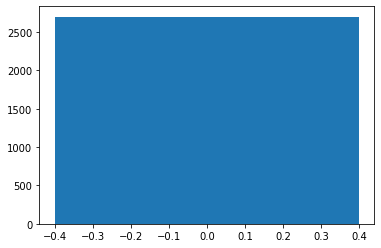

In [15]:
plt.bar(np.arange(num_components), np.bincount(smb_labels))
plt.show()

## Input Parameters

In [16]:
########################################################
## Input Parameters
#########################################################
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

## Dataset
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')

## GPU
parser.add_argument('--cuda', type=int, default=1,
                    help='use of cuda (default: 1)')
parser.add_argument('--gpuID', type=int, default=0,
                    help='set gpu id to use (default: 0)')

## Training
parser.add_argument('--epochs', type=int, default=num_epochs,
                    help='number of total epochs to run (default: 200)')
parser.add_argument('--batch_size', default=64, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int, 
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--num_classes', type=int, default=num_components,
                    help='number of classes (default: 10)')  # edited for this task
parser.add_argument('--gaussian_size', default=64, type=int,
                    help='gaussian size (default: 64)')
parser.add_argument('--input_size', default=3072, type=int,
                    help='input size (default: 784)')  # edited for this task

## Partition parameters
parser.add_argument('--train_proportion', default=0.9, type=float,
                    help='proportion of examples to consider for training only (default: 1.0)')

## Gumbel parameters
parser.add_argument('--init_temp', default=1.0, type=float,
                    help='Initial temperature used in gumbel-softmax (recommended 0.5-1.0, default:1.0)')
parser.add_argument('--decay_temp', default=1, type=int, 
                    help='Set 1 to decay gumbel temperature at every epoch (default: 1)')
parser.add_argument('--hard_gumbel', default=0, type=int, 
                    help='Set 1 to use the hard version of gumbel-softmax (default: 1)')
parser.add_argument('--min_temp', default=0.5, type=float, 
                    help='Minimum temperature of gumbel-softmax after annealing (default: 0.5)' )
parser.add_argument('--decay_temp_rate', default=0.013862944, type=float,
                    help='Temperature decay rate at every epoch (default: 0.013862944)')

## Loss function parameters
parser.add_argument('--w_gauss', default=2, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')

args = parser.parse_args()

Set random seed in case it was specified in the parameters


In [17]:
## Random Seed
SEED = args.seed
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if args.cuda:
    torch.cuda.manual_seed(SEED)

## Data Partition

We split the training data into train and validation according to the *train_proportion* parameter:

In [18]:
from torch.utils.data import TensorDataset, DataLoader

In [19]:
assert args.train_proportion != 1

In [20]:
def partition_dataset(n, proportion=1):
   train_num = int(n * proportion)
   indices = np.random.permutation(n)
   train_indices, val_indices = indices[:train_num], indices[train_num:]
   return train_indices, val_indices

train_indices, val_indices = partition_dataset(len(chunks), args.train_proportion)
train_ds = TensorDataset(torch.from_numpy(chunks).float(), torch.from_numpy(labels).long())
train_dl = DataLoader(train_ds, batch_size=args.batch_size, sampler=SubsetRandomSampler(train_indices))
valid_dl = DataLoader(train_ds, batch_size=args.batch_size_val, sampler=SubsetRandomSampler(val_indices))

## Train Model

In [22]:
# Model Initialization
gmvae = GMVAE(args)

In [ ]:
history_loss = gmvae.train(train_dl, valid_dl)

(Epoch 1 / 10000) Train_Loss: 488.716; Val_Loss: 243.471   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2 / 10000) Train_Loss: 230.644; Val_Loss: 229.617   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3 / 10000) Train_Loss: 227.834; Val_Loss: 233.581   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4 / 10000) Train_Loss: 222.054; Val_Loss: 224.113   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5 / 10000) Train_Loss: 216.347; Val_Loss: 219.337   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6 / 10000) Train_Loss: 212.784; Val_Loss: 211.886   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7 / 10000) Train_Loss: 210.169; Val_Loss: 211.043   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8 / 10000) Train_Loss: 208.113; Val_Loss: 211.60

(Epoch 62 / 10000) Train_Loss: 141.573; Val_Loss: 170.372   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 63 / 10000) Train_Loss: 140.542; Val_Loss: 168.863   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 64 / 10000) Train_Loss: 139.731; Val_Loss: 163.397   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 65 / 10000) Train_Loss: 139.813; Val_Loss: 166.431   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 66 / 10000) Train_Loss: 139.774; Val_Loss: 169.608   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 67 / 10000) Train_Loss: 138.357; Val_Loss: 166.278   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 68 / 10000) Train_Loss: 137.451; Val_Loss: 164.887   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 69 / 10000) Train_Loss: 136.877; Val_Loss

(Epoch 123 / 10000) Train_Loss: 112.033; Val_Loss: 184.343   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 124 / 10000) Train_Loss: 111.644; Val_Loss: 179.785   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 125 / 10000) Train_Loss: 111.968; Val_Loss: 182.309   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 126 / 10000) Train_Loss: 111.345; Val_Loss: 182.416   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 127 / 10000) Train_Loss: 110.454; Val_Loss: 176.103   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 128 / 10000) Train_Loss: 110.818; Val_Loss: 179.787   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 129 / 10000) Train_Loss: 110.493; Val_Loss: 186.623   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 130 / 10000) Train_Loss: 110.714; 

(Epoch 183 / 10000) Train_Loss: 96.298; Val_Loss: 227.934   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 184 / 10000) Train_Loss: 94.054; Val_Loss: 218.366   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 185 / 10000) Train_Loss: 94.960; Val_Loss: 212.407   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 186 / 10000) Train_Loss: 92.098; Val_Loss: 212.322   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 187 / 10000) Train_Loss: 91.789; Val_Loss: 218.129   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 188 / 10000) Train_Loss: 91.534; Val_Loss: 218.101   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 189 / 10000) Train_Loss: 90.962; Val_Loss: 225.635   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 190 / 10000) Train_Loss: 91.230; Val_Loss

(Epoch 244 / 10000) Train_Loss: 80.902; Val_Loss: 260.822   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 245 / 10000) Train_Loss: 82.793; Val_Loss: 275.267   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 246 / 10000) Train_Loss: 81.793; Val_Loss: 251.214   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 247 / 10000) Train_Loss: 79.648; Val_Loss: 266.413   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 248 / 10000) Train_Loss: 77.738; Val_Loss: 276.139   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 249 / 10000) Train_Loss: 78.705; Val_Loss: 260.778   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 250 / 10000) Train_Loss: 77.433; Val_Loss: 272.090   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 251 / 10000) Train_Loss: 77.363; Val_Loss

(Epoch 305 / 10000) Train_Loss: 71.508; Val_Loss: 337.350   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 306 / 10000) Train_Loss: 71.304; Val_Loss: 326.235   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 307 / 10000) Train_Loss: 70.633; Val_Loss: 323.941   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 308 / 10000) Train_Loss: 69.273; Val_Loss: 337.100   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 309 / 10000) Train_Loss: 68.303; Val_Loss: 324.997   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 310 / 10000) Train_Loss: 69.034; Val_Loss: 326.524   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 311 / 10000) Train_Loss: 70.538; Val_Loss: 324.518   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 312 / 10000) Train_Loss: 70.309; Val_Loss

(Epoch 366 / 10000) Train_Loss: 62.863; Val_Loss: 366.500   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 367 / 10000) Train_Loss: 62.761; Val_Loss: 378.913   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 368 / 10000) Train_Loss: 62.516; Val_Loss: 365.040   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 369 / 10000) Train_Loss: 61.990; Val_Loss: 379.599   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 370 / 10000) Train_Loss: 61.955; Val_Loss: 373.482   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 371 / 10000) Train_Loss: 62.432; Val_Loss: 376.269   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 372 / 10000) Train_Loss: 62.850; Val_Loss: 365.007   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 373 / 10000) Train_Loss: 61.969; Val_Loss

(Epoch 427 / 10000) Train_Loss: 57.903; Val_Loss: 413.254   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 428 / 10000) Train_Loss: 58.043; Val_Loss: 422.462   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 429 / 10000) Train_Loss: 58.226; Val_Loss: 443.146   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 430 / 10000) Train_Loss: 58.144; Val_Loss: 403.333   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 431 / 10000) Train_Loss: 58.215; Val_Loss: 420.791   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 432 / 10000) Train_Loss: 60.540; Val_Loss: 429.208   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 433 / 10000) Train_Loss: 63.224; Val_Loss: 446.324   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 434 / 10000) Train_Loss: 62.509; Val_Loss

(Epoch 488 / 10000) Train_Loss: 55.955; Val_Loss: 437.156   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 489 / 10000) Train_Loss: 53.700; Val_Loss: 451.196   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 490 / 10000) Train_Loss: 52.525; Val_Loss: 483.791   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 491 / 10000) Train_Loss: 52.771; Val_Loss: 477.907   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 492 / 10000) Train_Loss: 53.570; Val_Loss: 478.485   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 493 / 10000) Train_Loss: 53.680; Val_Loss: 484.506   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 494 / 10000) Train_Loss: 55.134; Val_Loss: 500.882   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 495 / 10000) Train_Loss: 55.336; Val_Loss

(Epoch 549 / 10000) Train_Loss: 50.099; Val_Loss: 496.727   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 550 / 10000) Train_Loss: 52.256; Val_Loss: 506.788   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 551 / 10000) Train_Loss: 51.004; Val_Loss: 469.806   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 552 / 10000) Train_Loss: 49.858; Val_Loss: 501.806   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 553 / 10000) Train_Loss: 49.008; Val_Loss: 497.791   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 554 / 10000) Train_Loss: 49.344; Val_Loss: 524.052   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 555 / 10000) Train_Loss: 50.349; Val_Loss: 498.828   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 556 / 10000) Train_Loss: 50.441; Val_Loss

(Epoch 610 / 10000) Train_Loss: 55.265; Val_Loss: 525.137   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 611 / 10000) Train_Loss: 51.850; Val_Loss: 521.981   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 612 / 10000) Train_Loss: 50.973; Val_Loss: 515.376   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 613 / 10000) Train_Loss: 48.888; Val_Loss: 497.212   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 614 / 10000) Train_Loss: 48.502; Val_Loss: 552.493   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 615 / 10000) Train_Loss: 47.772; Val_Loss: 556.106   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 616 / 10000) Train_Loss: 47.876; Val_Loss: 553.386   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 617 / 10000) Train_Loss: 49.560; Val_Loss

(Epoch 671 / 10000) Train_Loss: 51.248; Val_Loss: 633.954   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 672 / 10000) Train_Loss: 52.421; Val_Loss: 583.274   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 673 / 10000) Train_Loss: 49.059; Val_Loss: 553.105   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 674 / 10000) Train_Loss: 51.257; Val_Loss: 556.777   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 675 / 10000) Train_Loss: 52.292; Val_Loss: 572.956   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 676 / 10000) Train_Loss: 50.619; Val_Loss: 577.884   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 677 / 10000) Train_Loss: 48.179; Val_Loss: 542.010   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 678 / 10000) Train_Loss: 48.811; Val_Loss

(Epoch 732 / 10000) Train_Loss: 44.032; Val_Loss: 587.626   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 733 / 10000) Train_Loss: 44.431; Val_Loss: 596.750   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 734 / 10000) Train_Loss: 45.538; Val_Loss: 624.501   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 735 / 10000) Train_Loss: 44.481; Val_Loss: 568.492   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 736 / 10000) Train_Loss: 44.137; Val_Loss: 597.788   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 737 / 10000) Train_Loss: 45.035; Val_Loss: 612.348   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 738 / 10000) Train_Loss: 44.101; Val_Loss: 623.210   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 739 / 10000) Train_Loss: 44.745; Val_Loss

(Epoch 793 / 10000) Train_Loss: 51.266; Val_Loss: 644.607   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 794 / 10000) Train_Loss: 49.437; Val_Loss: 651.432   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 795 / 10000) Train_Loss: 49.027; Val_Loss: 620.581   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 796 / 10000) Train_Loss: 45.413; Val_Loss: 610.938   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 797 / 10000) Train_Loss: 45.075; Val_Loss: 629.750   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 798 / 10000) Train_Loss: 43.353; Val_Loss: 646.657   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 799 / 10000) Train_Loss: 43.719; Val_Loss: 640.657   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 800 / 10000) Train_Loss: 43.923; Val_Loss

(Epoch 854 / 10000) Train_Loss: 47.760; Val_Loss: 658.721   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 855 / 10000) Train_Loss: 51.695; Val_Loss: 673.447   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 856 / 10000) Train_Loss: 53.207; Val_Loss: 656.539   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 857 / 10000) Train_Loss: 52.374; Val_Loss: 677.867   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 858 / 10000) Train_Loss: 47.750; Val_Loss: 658.527   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 859 / 10000) Train_Loss: 44.382; Val_Loss: 665.946   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 860 / 10000) Train_Loss: 42.586; Val_Loss: 642.377   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 861 / 10000) Train_Loss: 43.705; Val_Loss

(Epoch 915 / 10000) Train_Loss: 41.437; Val_Loss: 685.249   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 916 / 10000) Train_Loss: 41.213; Val_Loss: 663.088   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 917 / 10000) Train_Loss: 43.747; Val_Loss: 689.167   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 918 / 10000) Train_Loss: 43.606; Val_Loss: 690.382   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 919 / 10000) Train_Loss: 46.823; Val_Loss: 722.897   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 920 / 10000) Train_Loss: 52.294; Val_Loss: 659.871   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 921 / 10000) Train_Loss: 52.816; Val_Loss: 655.313   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 922 / 10000) Train_Loss: 55.593; Val_Loss

(Epoch 976 / 10000) Train_Loss: 46.188; Val_Loss: 658.148   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 977 / 10000) Train_Loss: 43.007; Val_Loss: 710.964   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 978 / 10000) Train_Loss: 40.068; Val_Loss: 700.267   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 979 / 10000) Train_Loss: 39.223; Val_Loss: 710.195   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 980 / 10000) Train_Loss: 38.245; Val_Loss: 726.410   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 981 / 10000) Train_Loss: 37.853; Val_Loss: 732.663   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 982 / 10000) Train_Loss: 38.443; Val_Loss: 688.591   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 983 / 10000) Train_Loss: 37.693; Val_Loss

(Epoch 1036 / 10000) Train_Loss: 38.471; Val_Loss: 738.988   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1037 / 10000) Train_Loss: 39.799; Val_Loss: 689.307   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1038 / 10000) Train_Loss: 41.166; Val_Loss: 750.184   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1039 / 10000) Train_Loss: 41.785; Val_Loss: 685.668   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1040 / 10000) Train_Loss: 45.006; Val_Loss: 692.127   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1041 / 10000) Train_Loss: 44.760; Val_Loss: 704.178   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1042 / 10000) Train_Loss: 43.870; Val_Loss: 706.541   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1043 / 10000) Train_Loss: 42.950; 

(Epoch 1096 / 10000) Train_Loss: 37.843; Val_Loss: 722.337   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1097 / 10000) Train_Loss: 38.809; Val_Loss: 708.396   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1098 / 10000) Train_Loss: 40.003; Val_Loss: 768.985   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1099 / 10000) Train_Loss: 40.642; Val_Loss: 737.734   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1100 / 10000) Train_Loss: 41.418; Val_Loss: 743.827   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1101 / 10000) Train_Loss: 39.883; Val_Loss: 729.095   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1102 / 10000) Train_Loss: 40.362; Val_Loss: 742.789   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1103 / 10000) Train_Loss: 41.210; 

(Epoch 1156 / 10000) Train_Loss: 50.382; Val_Loss: 753.698   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1157 / 10000) Train_Loss: 50.102; Val_Loss: 752.906   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1158 / 10000) Train_Loss: 48.532; Val_Loss: 687.190   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1159 / 10000) Train_Loss: 43.444; Val_Loss: 732.582   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1160 / 10000) Train_Loss: 39.459; Val_Loss: 711.991   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1161 / 10000) Train_Loss: 37.956; Val_Loss: 720.880   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1162 / 10000) Train_Loss: 36.633; Val_Loss: 739.053   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1163 / 10000) Train_Loss: 37.468; 

(Epoch 1216 / 10000) Train_Loss: 41.948; Val_Loss: 751.784   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1217 / 10000) Train_Loss: 43.828; Val_Loss: 801.962   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1218 / 10000) Train_Loss: 42.544; Val_Loss: 786.081   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1219 / 10000) Train_Loss: 41.183; Val_Loss: 760.411   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1220 / 10000) Train_Loss: 39.959; Val_Loss: 739.951   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1221 / 10000) Train_Loss: 38.633; Val_Loss: 743.916   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1222 / 10000) Train_Loss: 38.462; Val_Loss: 756.846   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1223 / 10000) Train_Loss: 38.069; 

(Epoch 1276 / 10000) Train_Loss: 38.256; Val_Loss: 784.685   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1277 / 10000) Train_Loss: 37.500; Val_Loss: 780.683   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1278 / 10000) Train_Loss: 36.782; Val_Loss: 807.143   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1279 / 10000) Train_Loss: 36.579; Val_Loss: 779.402   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1280 / 10000) Train_Loss: 37.302; Val_Loss: 803.447   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1281 / 10000) Train_Loss: 39.250; Val_Loss: 828.881   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1282 / 10000) Train_Loss: 37.938; Val_Loss: 775.292   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1283 / 10000) Train_Loss: 36.759; 

(Epoch 1336 / 10000) Train_Loss: 37.808; Val_Loss: 793.924   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1337 / 10000) Train_Loss: 38.715; Val_Loss: 781.478   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1338 / 10000) Train_Loss: 40.691; Val_Loss: 787.401   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1339 / 10000) Train_Loss: 41.212; Val_Loss: 824.036   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1340 / 10000) Train_Loss: 38.979; Val_Loss: 786.153   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1341 / 10000) Train_Loss: 39.786; Val_Loss: 774.189   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1342 / 10000) Train_Loss: 41.443; Val_Loss: 737.974   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1343 / 10000) Train_Loss: 43.061; 

(Epoch 1396 / 10000) Train_Loss: 40.183; Val_Loss: 814.334   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1397 / 10000) Train_Loss: 40.220; Val_Loss: 841.305   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1398 / 10000) Train_Loss: 38.726; Val_Loss: 824.341   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1399 / 10000) Train_Loss: 38.415; Val_Loss: 779.908   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1400 / 10000) Train_Loss: 36.766; Val_Loss: 787.843   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1401 / 10000) Train_Loss: 36.325; Val_Loss: 791.103   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1402 / 10000) Train_Loss: 36.867; Val_Loss: 785.493   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1403 / 10000) Train_Loss: 35.022; 

(Epoch 1456 / 10000) Train_Loss: 48.976; Val_Loss: 831.292   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1457 / 10000) Train_Loss: 47.543; Val_Loss: 813.972   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1458 / 10000) Train_Loss: 43.165; Val_Loss: 833.735   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1459 / 10000) Train_Loss: 40.104; Val_Loss: 807.911   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1460 / 10000) Train_Loss: 38.778; Val_Loss: 825.822   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1461 / 10000) Train_Loss: 36.758; Val_Loss: 774.752   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1462 / 10000) Train_Loss: 35.686; Val_Loss: 816.183   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1463 / 10000) Train_Loss: 35.407; 

(Epoch 1516 / 10000) Train_Loss: 34.171; Val_Loss: 811.634   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1517 / 10000) Train_Loss: 33.766; Val_Loss: 818.875   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1518 / 10000) Train_Loss: 33.693; Val_Loss: 815.165   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1519 / 10000) Train_Loss: 34.074; Val_Loss: 837.128   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1520 / 10000) Train_Loss: 34.517; Val_Loss: 840.341   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1521 / 10000) Train_Loss: 35.231; Val_Loss: 812.090   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1522 / 10000) Train_Loss: 35.452; Val_Loss: 824.815   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1523 / 10000) Train_Loss: 36.736; 

(Epoch 1576 / 10000) Train_Loss: 34.473; Val_Loss: 833.159   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1577 / 10000) Train_Loss: 34.174; Val_Loss: 816.633   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1578 / 10000) Train_Loss: 34.199; Val_Loss: 864.809   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1579 / 10000) Train_Loss: 33.442; Val_Loss: 881.830   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1580 / 10000) Train_Loss: 34.089; Val_Loss: 844.012   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1581 / 10000) Train_Loss: 34.173; Val_Loss: 829.555   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1582 / 10000) Train_Loss: 34.734; Val_Loss: 862.076   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1583 / 10000) Train_Loss: 34.303; 

(Epoch 1636 / 10000) Train_Loss: 34.473; Val_Loss: 854.149   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1637 / 10000) Train_Loss: 35.091; Val_Loss: 872.375   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1638 / 10000) Train_Loss: 36.186; Val_Loss: 852.988   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1639 / 10000) Train_Loss: 41.480; Val_Loss: 853.021   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1640 / 10000) Train_Loss: 40.074; Val_Loss: 864.021   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1641 / 10000) Train_Loss: 41.744; Val_Loss: 861.092   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1642 / 10000) Train_Loss: 43.697; Val_Loss: 878.549   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1643 / 10000) Train_Loss: 46.306; 

(Epoch 1799 / 10000) Train_Loss: 47.328; Val_Loss: 881.018   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1800 / 10000) Train_Loss: 44.422; Val_Loss: 867.097   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1801 / 10000) Train_Loss: 38.862; Val_Loss: 900.997   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1802 / 10000) Train_Loss: 36.648; Val_Loss: 868.345   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1803 / 10000) Train_Loss: 35.131; Val_Loss: 893.208   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1804 / 10000) Train_Loss: 35.144; Val_Loss: 901.727   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1805 / 10000) Train_Loss: 37.982; Val_Loss: 865.353   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1806 / 10000) Train_Loss: 36.442; 

(Epoch 1859 / 10000) Train_Loss: 61.176; Val_Loss: 860.031   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1860 / 10000) Train_Loss: 59.708; Val_Loss: 854.644   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1861 / 10000) Train_Loss: 42.771; Val_Loss: 871.383   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1862 / 10000) Train_Loss: 38.550; Val_Loss: 911.861   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1863 / 10000) Train_Loss: 35.298; Val_Loss: 894.445   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1864 / 10000) Train_Loss: 34.718; Val_Loss: 877.803   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1865 / 10000) Train_Loss: 34.906; Val_Loss: 881.606   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1866 / 10000) Train_Loss: 33.295; 

(Epoch 1919 / 10000) Train_Loss: 34.651; Val_Loss: 913.186   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1920 / 10000) Train_Loss: 34.358; Val_Loss: 894.769   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1921 / 10000) Train_Loss: 35.890; Val_Loss: 871.315   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1922 / 10000) Train_Loss: 37.573; Val_Loss: 863.763   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1923 / 10000) Train_Loss: 34.371; Val_Loss: 884.492   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1924 / 10000) Train_Loss: 33.539; Val_Loss: 903.414   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1925 / 10000) Train_Loss: 34.232; Val_Loss: 922.410   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1926 / 10000) Train_Loss: 34.574; 

(Epoch 1979 / 10000) Train_Loss: 34.636; Val_Loss: 919.654   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1980 / 10000) Train_Loss: 35.803; Val_Loss: 881.041   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1981 / 10000) Train_Loss: 34.914; Val_Loss: 895.366   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1982 / 10000) Train_Loss: 35.268; Val_Loss: 895.261   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1983 / 10000) Train_Loss: 37.632; Val_Loss: 924.255   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1984 / 10000) Train_Loss: 39.905; Val_Loss: 919.877   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1985 / 10000) Train_Loss: 38.178; Val_Loss: 883.470   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 1986 / 10000) Train_Loss: 36.718; 

(Epoch 2039 / 10000) Train_Loss: 36.113; Val_Loss: 922.537   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2040 / 10000) Train_Loss: 34.862; Val_Loss: 895.995   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2041 / 10000) Train_Loss: 39.218; Val_Loss: 951.121   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2042 / 10000) Train_Loss: 45.172; Val_Loss: 874.438   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2043 / 10000) Train_Loss: 41.129; Val_Loss: 841.190   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2044 / 10000) Train_Loss: 38.452; Val_Loss: 898.475   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2045 / 10000) Train_Loss: 34.665; Val_Loss: 908.293   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2046 / 10000) Train_Loss: 33.008; 

(Epoch 2099 / 10000) Train_Loss: 44.092; Val_Loss: 908.575   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2100 / 10000) Train_Loss: 38.473; Val_Loss: 947.618   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2101 / 10000) Train_Loss: 35.154; Val_Loss: 869.748   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2102 / 10000) Train_Loss: 32.636; Val_Loss: 932.997   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2103 / 10000) Train_Loss: 31.991; Val_Loss: 889.443   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2104 / 10000) Train_Loss: 32.145; Val_Loss: 907.747   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2105 / 10000) Train_Loss: 32.232; Val_Loss: 890.404   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2106 / 10000) Train_Loss: 32.698; 

(Epoch 2159 / 10000) Train_Loss: 33.880; Val_Loss: 913.801   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2160 / 10000) Train_Loss: 35.220; Val_Loss: 837.058   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2161 / 10000) Train_Loss: 35.214; Val_Loss: 945.940   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2162 / 10000) Train_Loss: 33.534; Val_Loss: 883.611   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2163 / 10000) Train_Loss: 33.956; Val_Loss: 952.848   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2164 / 10000) Train_Loss: 33.394; Val_Loss: 923.730   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2165 / 10000) Train_Loss: 33.080; Val_Loss: 915.984   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2166 / 10000) Train_Loss: 33.537; 

(Epoch 2219 / 10000) Train_Loss: 40.246; Val_Loss: 913.350   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2220 / 10000) Train_Loss: 56.119; Val_Loss: 929.980   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2221 / 10000) Train_Loss: 61.954; Val_Loss: 966.173   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2222 / 10000) Train_Loss: 53.248; Val_Loss: 902.480   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2223 / 10000) Train_Loss: 43.326; Val_Loss: 919.398   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2224 / 10000) Train_Loss: 38.064; Val_Loss: 869.989   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2225 / 10000) Train_Loss: 34.744; Val_Loss: 916.903   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2226 / 10000) Train_Loss: 33.224; 

(Epoch 2279 / 10000) Train_Loss: 32.168; Val_Loss: 909.735   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2280 / 10000) Train_Loss: 31.405; Val_Loss: 913.307   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2281 / 10000) Train_Loss: 32.849; Val_Loss: 916.247   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2282 / 10000) Train_Loss: 34.148; Val_Loss: 884.456   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2283 / 10000) Train_Loss: 32.633; Val_Loss: 1000.600   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2284 / 10000) Train_Loss: 35.367; Val_Loss: 921.506   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2285 / 10000) Train_Loss: 39.206; Val_Loss: 942.918   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2286 / 10000) Train_Loss: 40.052;

(Epoch 2339 / 10000) Train_Loss: 33.346; Val_Loss: 936.840   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2340 / 10000) Train_Loss: 32.980; Val_Loss: 949.278   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2341 / 10000) Train_Loss: 32.803; Val_Loss: 928.932   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2342 / 10000) Train_Loss: 34.446; Val_Loss: 919.739   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2343 / 10000) Train_Loss: 35.706; Val_Loss: 963.643   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2344 / 10000) Train_Loss: 36.680; Val_Loss: 933.441   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2345 / 10000) Train_Loss: 40.135; Val_Loss: 916.101   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2346 / 10000) Train_Loss: 38.398; 

(Epoch 2399 / 10000) Train_Loss: 31.919; Val_Loss: 908.634   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2400 / 10000) Train_Loss: 37.642; Val_Loss: 976.957   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2401 / 10000) Train_Loss: 34.665; Val_Loss: 922.485   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2402 / 10000) Train_Loss: 33.150; Val_Loss: 916.673   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2403 / 10000) Train_Loss: 33.040; Val_Loss: 981.687   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2404 / 10000) Train_Loss: 32.720; Val_Loss: 948.408   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2405 / 10000) Train_Loss: 32.091; Val_Loss: 905.108   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2406 / 10000) Train_Loss: 31.624; 

(Epoch 2459 / 10000) Train_Loss: 41.099; Val_Loss: 970.413   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2460 / 10000) Train_Loss: 39.425; Val_Loss: 985.202   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2461 / 10000) Train_Loss: 37.788; Val_Loss: 948.495   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2462 / 10000) Train_Loss: 33.861; Val_Loss: 914.196   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2463 / 10000) Train_Loss: 32.063; Val_Loss: 939.512   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2464 / 10000) Train_Loss: 31.712; Val_Loss: 952.037   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2465 / 10000) Train_Loss: 31.394; Val_Loss: 920.554   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2466 / 10000) Train_Loss: 32.516; 

(Epoch 2519 / 10000) Train_Loss: 31.321; Val_Loss: 962.768   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2520 / 10000) Train_Loss: 31.981; Val_Loss: 934.380   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2521 / 10000) Train_Loss: 31.441; Val_Loss: 893.812   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2522 / 10000) Train_Loss: 31.280; Val_Loss: 920.038   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2523 / 10000) Train_Loss: 31.525; Val_Loss: 903.155   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2524 / 10000) Train_Loss: 31.703; Val_Loss: 929.942   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2525 / 10000) Train_Loss: 34.464; Val_Loss: 906.194   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2526 / 10000) Train_Loss: 34.560; 

(Epoch 2579 / 10000) Train_Loss: 34.257; Val_Loss: 985.199   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2580 / 10000) Train_Loss: 41.067; Val_Loss: 959.984   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2581 / 10000) Train_Loss: 45.462; Val_Loss: 948.020   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2582 / 10000) Train_Loss: 48.661; Val_Loss: 955.350   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2583 / 10000) Train_Loss: 48.370; Val_Loss: 972.810   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2584 / 10000) Train_Loss: 41.748; Val_Loss: 897.442   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2585 / 10000) Train_Loss: 36.700; Val_Loss: 937.757   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2586 / 10000) Train_Loss: 32.647; 

(Epoch 2639 / 10000) Train_Loss: 32.163; Val_Loss: 927.673   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2640 / 10000) Train_Loss: 31.007; Val_Loss: 964.879   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2641 / 10000) Train_Loss: 32.069; Val_Loss: 982.126   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2642 / 10000) Train_Loss: 32.299; Val_Loss: 1010.218   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2643 / 10000) Train_Loss: 32.814; Val_Loss: 963.586   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2644 / 10000) Train_Loss: 32.656; Val_Loss: 954.061   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2645 / 10000) Train_Loss: 35.319; Val_Loss: 965.668   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2646 / 10000) Train_Loss: 37.290;

(Epoch 2699 / 10000) Train_Loss: 35.233; Val_Loss: 981.842   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2700 / 10000) Train_Loss: 32.287; Val_Loss: 988.979   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2701 / 10000) Train_Loss: 31.739; Val_Loss: 942.948   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2702 / 10000) Train_Loss: 30.616; Val_Loss: 981.716   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2703 / 10000) Train_Loss: 31.178; Val_Loss: 994.302   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2704 / 10000) Train_Loss: 31.039; Val_Loss: 960.298   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2705 / 10000) Train_Loss: 31.548; Val_Loss: 943.793   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2706 / 10000) Train_Loss: 31.991; 

(Epoch 2759 / 10000) Train_Loss: 32.347; Val_Loss: 975.256   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2760 / 10000) Train_Loss: 31.765; Val_Loss: 954.477   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2761 / 10000) Train_Loss: 31.930; Val_Loss: 1026.931   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2762 / 10000) Train_Loss: 32.012; Val_Loss: 953.132   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2763 / 10000) Train_Loss: 32.038; Val_Loss: 967.740   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2764 / 10000) Train_Loss: 31.718; Val_Loss: 987.764   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2765 / 10000) Train_Loss: 31.707; Val_Loss: 987.466   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2766 / 10000) Train_Loss: 32.500;

(Epoch 2819 / 10000) Train_Loss: 30.712; Val_Loss: 984.790   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2820 / 10000) Train_Loss: 31.074; Val_Loss: 910.379   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2821 / 10000) Train_Loss: 32.241; Val_Loss: 941.830   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2822 / 10000) Train_Loss: 31.803; Val_Loss: 1022.722   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2823 / 10000) Train_Loss: 34.135; Val_Loss: 975.855   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2824 / 10000) Train_Loss: 34.307; Val_Loss: 988.612   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2825 / 10000) Train_Loss: 32.971; Val_Loss: 969.717   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2826 / 10000) Train_Loss: 32.134;

(Epoch 2879 / 10000) Train_Loss: 34.746; Val_Loss: 1015.024   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2880 / 10000) Train_Loss: 31.676; Val_Loss: 998.379   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2881 / 10000) Train_Loss: 31.220; Val_Loss: 1009.758   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2882 / 10000) Train_Loss: 36.130; Val_Loss: 998.158   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2883 / 10000) Train_Loss: 35.867; Val_Loss: 969.690   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2884 / 10000) Train_Loss: 35.600; Val_Loss: 1033.708   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2885 / 10000) Train_Loss: 32.531; Val_Loss: 1021.308   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2886 / 10000) Train_Loss: 31.3

(Epoch 2939 / 10000) Train_Loss: 31.984; Val_Loss: 987.366   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2940 / 10000) Train_Loss: 33.432; Val_Loss: 1000.172   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2941 / 10000) Train_Loss: 33.796; Val_Loss: 976.709   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2942 / 10000) Train_Loss: 31.701; Val_Loss: 996.923   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2943 / 10000) Train_Loss: 31.972; Val_Loss: 948.903   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2944 / 10000) Train_Loss: 31.189; Val_Loss: 1017.350   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2945 / 10000) Train_Loss: 34.189; Val_Loss: 1044.294   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 2946 / 10000) Train_Loss: 37.88

(Epoch 2999 / 10000) Train_Loss: 35.015; Val_Loss: 958.343   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3000 / 10000) Train_Loss: 32.736; Val_Loss: 1020.292   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3001 / 10000) Train_Loss: 32.685; Val_Loss: 957.249   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3002 / 10000) Train_Loss: 32.090; Val_Loss: 970.808   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3003 / 10000) Train_Loss: 32.329; Val_Loss: 986.163   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3004 / 10000) Train_Loss: 32.808; Val_Loss: 980.558   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3005 / 10000) Train_Loss: 32.080; Val_Loss: 1041.476   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3006 / 10000) Train_Loss: 31.940

(Epoch 3059 / 10000) Train_Loss: 30.657; Val_Loss: 954.305   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3060 / 10000) Train_Loss: 30.918; Val_Loss: 1009.671   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3061 / 10000) Train_Loss: 33.425; Val_Loss: 1021.190   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3062 / 10000) Train_Loss: 35.241; Val_Loss: 1071.683   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3063 / 10000) Train_Loss: 32.244; Val_Loss: 1012.917   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3064 / 10000) Train_Loss: 31.657; Val_Loss: 1000.535   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3065 / 10000) Train_Loss: 30.916; Val_Loss: 952.473   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3066 / 10000) Train_Loss: 31.

(Epoch 3119 / 10000) Train_Loss: 31.565; Val_Loss: 995.857   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3120 / 10000) Train_Loss: 31.239; Val_Loss: 997.385   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3121 / 10000) Train_Loss: 30.116; Val_Loss: 1026.968   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3122 / 10000) Train_Loss: 30.049; Val_Loss: 917.551   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3123 / 10000) Train_Loss: 31.079; Val_Loss: 1004.617   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3124 / 10000) Train_Loss: 30.610; Val_Loss: 1034.737   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3125 / 10000) Train_Loss: 31.496; Val_Loss: 1008.553   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3126 / 10000) Train_Loss: 33.6

(Epoch 3179 / 10000) Train_Loss: 42.995; Val_Loss: 947.670   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3180 / 10000) Train_Loss: 35.591; Val_Loss: 1036.117   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3181 / 10000) Train_Loss: 32.194; Val_Loss: 987.508   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3182 / 10000) Train_Loss: 30.612; Val_Loss: 975.527   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3183 / 10000) Train_Loss: 29.938; Val_Loss: 954.757   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3184 / 10000) Train_Loss: 29.924; Val_Loss: 969.834   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3185 / 10000) Train_Loss: 31.549; Val_Loss: 936.959   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3186 / 10000) Train_Loss: 31.082;

(Epoch 3239 / 10000) Train_Loss: 31.558; Val_Loss: 1028.413   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3240 / 10000) Train_Loss: 31.266; Val_Loss: 991.260   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3241 / 10000) Train_Loss: 30.931; Val_Loss: 1045.701   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3242 / 10000) Train_Loss: 30.928; Val_Loss: 1029.029   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3243 / 10000) Train_Loss: 31.775; Val_Loss: 1029.874   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3244 / 10000) Train_Loss: 42.152; Val_Loss: 1058.760   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3245 / 10000) Train_Loss: 60.544; Val_Loss: 1009.091   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3246 / 10000) Train_Loss: 53

(Epoch 3299 / 10000) Train_Loss: 34.303; Val_Loss: 1004.689   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3300 / 10000) Train_Loss: 36.113; Val_Loss: 1004.089   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3301 / 10000) Train_Loss: 35.173; Val_Loss: 1008.409   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3302 / 10000) Train_Loss: 34.558; Val_Loss: 1001.871   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3303 / 10000) Train_Loss: 32.313; Val_Loss: 1032.636   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3304 / 10000) Train_Loss: 31.623; Val_Loss: 1035.794   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3305 / 10000) Train_Loss: 31.697; Val_Loss: 976.067   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3306 / 10000) Train_Loss: 32

(Epoch 3359 / 10000) Train_Loss: 31.611; Val_Loss: 1006.980   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3360 / 10000) Train_Loss: 31.804; Val_Loss: 1012.271   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3361 / 10000) Train_Loss: 31.632; Val_Loss: 1019.148   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3362 / 10000) Train_Loss: 32.160; Val_Loss: 1012.294   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3363 / 10000) Train_Loss: 33.468; Val_Loss: 1040.922   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3364 / 10000) Train_Loss: 33.677; Val_Loss: 1016.149   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3365 / 10000) Train_Loss: 32.134; Val_Loss: 1012.608   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3366 / 10000) Train_Loss: 3

(Epoch 3419 / 10000) Train_Loss: 30.065; Val_Loss: 982.649   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3420 / 10000) Train_Loss: 30.050; Val_Loss: 1055.861   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3421 / 10000) Train_Loss: 30.945; Val_Loss: 952.972   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3422 / 10000) Train_Loss: 31.139; Val_Loss: 1010.278   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3423 / 10000) Train_Loss: 30.528; Val_Loss: 974.540   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3424 / 10000) Train_Loss: 32.555; Val_Loss: 985.110   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3425 / 10000) Train_Loss: 33.226; Val_Loss: 1032.848   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3426 / 10000) Train_Loss: 32.80

(Epoch 3479 / 10000) Train_Loss: 34.427; Val_Loss: 1009.385   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3480 / 10000) Train_Loss: 35.198; Val_Loss: 1014.346   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3481 / 10000) Train_Loss: 33.162; Val_Loss: 1004.790   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3482 / 10000) Train_Loss: 31.264; Val_Loss: 1016.645   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3484 / 10000) Train_Loss: 31.506; Val_Loss: 1028.873   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3485 / 10000) Train_Loss: 30.989; Val_Loss: 995.873   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3486 / 10000) Train_Loss: 31.960; Val_Loss: 1062.165   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3487 / 10000) Train_Loss: 31

(Epoch 3615 / 10000) Train_Loss: 32.807; Val_Loss: 1035.347   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3616 / 10000) Train_Loss: 31.169; Val_Loss: 975.725   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3617 / 10000) Train_Loss: 32.664; Val_Loss: 1033.695   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3618 / 10000) Train_Loss: 33.154; Val_Loss: 1013.781   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3619 / 10000) Train_Loss: 34.518; Val_Loss: 994.737   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3620 / 10000) Train_Loss: 34.178; Val_Loss: 1051.644   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3621 / 10000) Train_Loss: 33.866; Val_Loss: 1017.220   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3622 / 10000) Train_Loss: 32.

(Epoch 3675 / 10000) Train_Loss: 32.157; Val_Loss: 1028.083   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3676 / 10000) Train_Loss: 31.115; Val_Loss: 1010.525   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3677 / 10000) Train_Loss: 31.179; Val_Loss: 1056.941   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3678 / 10000) Train_Loss: 30.889; Val_Loss: 1021.856   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3679 / 10000) Train_Loss: 31.321; Val_Loss: 957.185   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3680 / 10000) Train_Loss: 31.778; Val_Loss: 982.476   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3681 / 10000) Train_Loss: 34.629; Val_Loss: 1049.551   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3682 / 10000) Train_Loss: 32.

(Epoch 3735 / 10000) Train_Loss: 35.330; Val_Loss: 1025.486   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3736 / 10000) Train_Loss: 37.729; Val_Loss: 952.825   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3737 / 10000) Train_Loss: 37.307; Val_Loss: 981.361   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3738 / 10000) Train_Loss: 36.021; Val_Loss: 1020.304   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3739 / 10000) Train_Loss: 32.777; Val_Loss: 1055.075   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3740 / 10000) Train_Loss: 31.376; Val_Loss: 1023.511   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3741 / 10000) Train_Loss: 33.233; Val_Loss: 1048.736   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3742 / 10000) Train_Loss: 35.

(Epoch 3795 / 10000) Train_Loss: 31.414; Val_Loss: 955.758   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3796 / 10000) Train_Loss: 30.717; Val_Loss: 992.132   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3797 / 10000) Train_Loss: 29.824; Val_Loss: 1047.067   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3798 / 10000) Train_Loss: 30.238; Val_Loss: 1019.748   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3799 / 10000) Train_Loss: 30.030; Val_Loss: 972.867   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3800 / 10000) Train_Loss: 30.542; Val_Loss: 1022.584   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3801 / 10000) Train_Loss: 30.592; Val_Loss: 1053.972   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3802 / 10000) Train_Loss: 32.7

(Epoch 3855 / 10000) Train_Loss: 33.465; Val_Loss: 1000.571   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3856 / 10000) Train_Loss: 31.686; Val_Loss: 1087.043   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3857 / 10000) Train_Loss: 33.635; Val_Loss: 1066.293   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3858 / 10000) Train_Loss: 31.496; Val_Loss: 1004.803   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3859 / 10000) Train_Loss: 30.844; Val_Loss: 984.332   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3860 / 10000) Train_Loss: 30.674; Val_Loss: 1056.523   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3861 / 10000) Train_Loss: 31.411; Val_Loss: 1027.100   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3862 / 10000) Train_Loss: 31

(Epoch 3915 / 10000) Train_Loss: 34.315; Val_Loss: 1033.993   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3916 / 10000) Train_Loss: 32.922; Val_Loss: 1065.064   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3917 / 10000) Train_Loss: 31.790; Val_Loss: 1086.328   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3918 / 10000) Train_Loss: 32.469; Val_Loss: 996.111   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3919 / 10000) Train_Loss: 31.015; Val_Loss: 1021.688   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3920 / 10000) Train_Loss: 31.038; Val_Loss: 979.413   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3921 / 10000) Train_Loss: 30.722; Val_Loss: 1036.768   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3922 / 10000) Train_Loss: 31.

(Epoch 3975 / 10000) Train_Loss: 30.490; Val_Loss: 1075.006   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3976 / 10000) Train_Loss: 30.051; Val_Loss: 1038.609   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3977 / 10000) Train_Loss: 30.643; Val_Loss: 1078.695   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3978 / 10000) Train_Loss: 32.648; Val_Loss: 1067.509   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3979 / 10000) Train_Loss: 32.265; Val_Loss: 1047.509   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3980 / 10000) Train_Loss: 30.416; Val_Loss: 1076.412   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3981 / 10000) Train_Loss: 32.631; Val_Loss: 1086.060   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 3982 / 10000) Train_Loss: 3

(Epoch 4035 / 10000) Train_Loss: 30.424; Val_Loss: 1094.730   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4036 / 10000) Train_Loss: 29.719; Val_Loss: 1048.741   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4037 / 10000) Train_Loss: 31.348; Val_Loss: 1053.728   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4038 / 10000) Train_Loss: 34.169; Val_Loss: 1027.027   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4039 / 10000) Train_Loss: 35.432; Val_Loss: 1052.999   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4040 / 10000) Train_Loss: 34.258; Val_Loss: 1085.468   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4041 / 10000) Train_Loss: 36.612; Val_Loss: 1049.784   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4042 / 10000) Train_Loss: 5

(Epoch 4095 / 10000) Train_Loss: 33.836; Val_Loss: 1093.452   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4096 / 10000) Train_Loss: 31.267; Val_Loss: 1059.806   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4097 / 10000) Train_Loss: 30.220; Val_Loss: 1004.490   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4098 / 10000) Train_Loss: 30.518; Val_Loss: 1071.216   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4099 / 10000) Train_Loss: 30.154; Val_Loss: 984.328   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4100 / 10000) Train_Loss: 30.241; Val_Loss: 1083.701   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4101 / 10000) Train_Loss: 32.907; Val_Loss: 1063.256   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4102 / 10000) Train_Loss: 32

(Epoch 4155 / 10000) Train_Loss: 32.735; Val_Loss: 1062.943   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4156 / 10000) Train_Loss: 34.595; Val_Loss: 1058.046   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4157 / 10000) Train_Loss: 32.332; Val_Loss: 1077.189   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4158 / 10000) Train_Loss: 30.779; Val_Loss: 1034.440   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4159 / 10000) Train_Loss: 30.697; Val_Loss: 1064.788   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4160 / 10000) Train_Loss: 30.779; Val_Loss: 1064.540   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4161 / 10000) Train_Loss: 29.764; Val_Loss: 1057.634   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4162 / 10000) Train_Loss: 3

(Epoch 4215 / 10000) Train_Loss: 30.442; Val_Loss: 1078.251   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4216 / 10000) Train_Loss: 30.661; Val_Loss: 1070.843   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4217 / 10000) Train_Loss: 32.351; Val_Loss: 1116.688   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4218 / 10000) Train_Loss: 35.840; Val_Loss: 1089.087   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4219 / 10000) Train_Loss: 49.203; Val_Loss: 1087.418   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4220 / 10000) Train_Loss: 40.573; Val_Loss: 1088.382   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4221 / 10000) Train_Loss: 37.064; Val_Loss: 1026.748   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4222 / 10000) Train_Loss: 3

(Epoch 4275 / 10000) Train_Loss: 32.330; Val_Loss: 1061.596   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4276 / 10000) Train_Loss: 37.136; Val_Loss: 1048.398   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4277 / 10000) Train_Loss: 35.358; Val_Loss: 1057.641   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4278 / 10000) Train_Loss: 31.752; Val_Loss: 1059.074   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4279 / 10000) Train_Loss: 30.876; Val_Loss: 1015.893   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4280 / 10000) Train_Loss: 30.104; Val_Loss: 1057.716   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4281 / 10000) Train_Loss: 29.997; Val_Loss: 1068.916   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4282 / 10000) Train_Loss: 2

(Epoch 4335 / 10000) Train_Loss: 31.714; Val_Loss: 1016.382   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4336 / 10000) Train_Loss: 30.854; Val_Loss: 1024.725   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4337 / 10000) Train_Loss: 31.328; Val_Loss: 1059.221   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4338 / 10000) Train_Loss: 34.623; Val_Loss: 1064.513   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4339 / 10000) Train_Loss: 31.407; Val_Loss: 1056.587   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4340 / 10000) Train_Loss: 30.016; Val_Loss: 1063.904   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4341 / 10000) Train_Loss: 30.786; Val_Loss: 1021.591   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4342 / 10000) Train_Loss: 2

(Epoch 4395 / 10000) Train_Loss: 30.779; Val_Loss: 1096.294   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4396 / 10000) Train_Loss: 30.074; Val_Loss: 1031.250   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4397 / 10000) Train_Loss: 30.180; Val_Loss: 1051.837   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4398 / 10000) Train_Loss: 29.301; Val_Loss: 1051.489   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4399 / 10000) Train_Loss: 29.895; Val_Loss: 1052.644   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4400 / 10000) Train_Loss: 31.591; Val_Loss: 1091.730   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4401 / 10000) Train_Loss: 36.110; Val_Loss: 1107.283   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4402 / 10000) Train_Loss: 3

(Epoch 4455 / 10000) Train_Loss: 39.320; Val_Loss: 1087.921   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4456 / 10000) Train_Loss: 40.888; Val_Loss: 1113.530   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4457 / 10000) Train_Loss: 35.457; Val_Loss: 1068.443   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4458 / 10000) Train_Loss: 32.590; Val_Loss: 1054.173   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4459 / 10000) Train_Loss: 32.015; Val_Loss: 1092.183   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4460 / 10000) Train_Loss: 31.825; Val_Loss: 1014.467   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4461 / 10000) Train_Loss: 29.735; Val_Loss: 1054.350   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4462 / 10000) Train_Loss: 2

(Epoch 4515 / 10000) Train_Loss: 30.604; Val_Loss: 1076.735   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4516 / 10000) Train_Loss: 29.752; Val_Loss: 1084.626   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4517 / 10000) Train_Loss: 30.737; Val_Loss: 1045.172   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4518 / 10000) Train_Loss: 32.187; Val_Loss: 1145.035   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4519 / 10000) Train_Loss: 31.210; Val_Loss: 1067.206   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4520 / 10000) Train_Loss: 31.103; Val_Loss: 1055.240   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4521 / 10000) Train_Loss: 30.016; Val_Loss: 1087.800   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4522 / 10000) Train_Loss: 2

(Epoch 4575 / 10000) Train_Loss: 29.783; Val_Loss: 1064.859   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4576 / 10000) Train_Loss: 30.083; Val_Loss: 1044.312   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4577 / 10000) Train_Loss: 31.508; Val_Loss: 1104.848   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4578 / 10000) Train_Loss: 31.146; Val_Loss: 1125.144   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4579 / 10000) Train_Loss: 29.748; Val_Loss: 1073.994   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4580 / 10000) Train_Loss: 29.504; Val_Loss: 1097.550   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4581 / 10000) Train_Loss: 29.939; Val_Loss: 1100.258   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4582 / 10000) Train_Loss: 3

(Epoch 4711 / 10000) Train_Loss: 32.989; Val_Loss: 998.674   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4712 / 10000) Train_Loss: 33.648; Val_Loss: 1056.647   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4713 / 10000) Train_Loss: 31.882; Val_Loss: 1108.496   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4714 / 10000) Train_Loss: 29.600; Val_Loss: 1038.291   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4715 / 10000) Train_Loss: 28.963; Val_Loss: 1078.088   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4716 / 10000) Train_Loss: 30.007; Val_Loss: 1074.742   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4717 / 10000) Train_Loss: 29.436; Val_Loss: 1011.981   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4718 / 10000) Train_Loss: 29

(Epoch 4771 / 10000) Train_Loss: 33.134; Val_Loss: 1098.674   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4772 / 10000) Train_Loss: 31.062; Val_Loss: 1070.016   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4773 / 10000) Train_Loss: 32.465; Val_Loss: 1048.420   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4774 / 10000) Train_Loss: 32.546; Val_Loss: 1065.260   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4775 / 10000) Train_Loss: 30.259; Val_Loss: 1055.287   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4776 / 10000) Train_Loss: 31.611; Val_Loss: 1105.432   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4777 / 10000) Train_Loss: 33.065; Val_Loss: 1056.081   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4778 / 10000) Train_Loss: 3

(Epoch 4831 / 10000) Train_Loss: 30.870; Val_Loss: 1107.592   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4832 / 10000) Train_Loss: 35.377; Val_Loss: 1072.596   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4833 / 10000) Train_Loss: 31.158; Val_Loss: 1087.981   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4834 / 10000) Train_Loss: 30.353; Val_Loss: 1097.320   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4835 / 10000) Train_Loss: 31.305; Val_Loss: 1083.080   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4836 / 10000) Train_Loss: 29.656; Val_Loss: 1101.101   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4837 / 10000) Train_Loss: 29.266; Val_Loss: 1031.149   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4838 / 10000) Train_Loss: 2

(Epoch 4891 / 10000) Train_Loss: 29.337; Val_Loss: 1163.740   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4892 / 10000) Train_Loss: 28.842; Val_Loss: 1047.644   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4893 / 10000) Train_Loss: 30.048; Val_Loss: 1073.407   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4894 / 10000) Train_Loss: 30.688; Val_Loss: 1064.482   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4895 / 10000) Train_Loss: 30.528; Val_Loss: 1064.345   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4896 / 10000) Train_Loss: 31.441; Val_Loss: 1074.731   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4897 / 10000) Train_Loss: 32.313; Val_Loss: 1041.827   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4898 / 10000) Train_Loss: 3

(Epoch 4951 / 10000) Train_Loss: 32.401; Val_Loss: 1046.255   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4952 / 10000) Train_Loss: 34.199; Val_Loss: 1126.607   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4953 / 10000) Train_Loss: 31.777; Val_Loss: 1137.068   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4954 / 10000) Train_Loss: 29.164; Val_Loss: 1127.537   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4955 / 10000) Train_Loss: 29.328; Val_Loss: 1103.847   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4956 / 10000) Train_Loss: 29.398; Val_Loss: 1053.277   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4957 / 10000) Train_Loss: 28.903; Val_Loss: 1042.277   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 4958 / 10000) Train_Loss: 2

(Epoch 5011 / 10000) Train_Loss: 35.230; Val_Loss: 1059.537   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5012 / 10000) Train_Loss: 32.342; Val_Loss: 1072.167   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5013 / 10000) Train_Loss: 31.592; Val_Loss: 1117.947   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5014 / 10000) Train_Loss: 30.142; Val_Loss: 1088.827   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5015 / 10000) Train_Loss: 30.482; Val_Loss: 1081.525   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5016 / 10000) Train_Loss: 34.647; Val_Loss: 1100.691   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5017 / 10000) Train_Loss: 40.313; Val_Loss: 1072.669   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5018 / 10000) Train_Loss: 3

(Epoch 5071 / 10000) Train_Loss: 32.372; Val_Loss: 1033.792   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5072 / 10000) Train_Loss: 38.179; Val_Loss: 1095.646   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5073 / 10000) Train_Loss: 36.936; Val_Loss: 1102.120   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5074 / 10000) Train_Loss: 38.146; Val_Loss: 1067.269   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5075 / 10000) Train_Loss: 33.637; Val_Loss: 1067.149   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5076 / 10000) Train_Loss: 31.196; Val_Loss: 1088.724   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5077 / 10000) Train_Loss: 29.954; Val_Loss: 1150.930   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5078 / 10000) Train_Loss: 3

(Epoch 5131 / 10000) Train_Loss: 29.621; Val_Loss: 1072.973   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5132 / 10000) Train_Loss: 31.346; Val_Loss: 1138.497   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5133 / 10000) Train_Loss: 34.269; Val_Loss: 1129.367   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5134 / 10000) Train_Loss: 32.800; Val_Loss: 1116.997   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5135 / 10000) Train_Loss: 31.600; Val_Loss: 1062.745   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5136 / 10000) Train_Loss: 29.755; Val_Loss: 1061.434   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5137 / 10000) Train_Loss: 29.164; Val_Loss: 1110.776   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5138 / 10000) Train_Loss: 2

(Epoch 5191 / 10000) Train_Loss: 29.648; Val_Loss: 1113.462   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5192 / 10000) Train_Loss: 32.041; Val_Loss: 1108.639   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5193 / 10000) Train_Loss: 32.772; Val_Loss: 1140.620   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5194 / 10000) Train_Loss: 31.106; Val_Loss: 1063.603   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5195 / 10000) Train_Loss: 31.251; Val_Loss: 1056.711   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5196 / 10000) Train_Loss: 37.240; Val_Loss: 1052.568   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5197 / 10000) Train_Loss: 43.153; Val_Loss: 1095.050   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5198 / 10000) Train_Loss: 3

(Epoch 5251 / 10000) Train_Loss: 34.247; Val_Loss: 1052.681   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5252 / 10000) Train_Loss: 31.892; Val_Loss: 1099.900   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5253 / 10000) Train_Loss: 32.944; Val_Loss: 1096.348   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5254 / 10000) Train_Loss: 29.710; Val_Loss: 1060.054   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5255 / 10000) Train_Loss: 29.187; Val_Loss: 1099.961   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5256 / 10000) Train_Loss: 28.849; Val_Loss: 1143.154   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5257 / 10000) Train_Loss: 28.753; Val_Loss: 1144.300   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5258 / 10000) Train_Loss: 3

(Epoch 5311 / 10000) Train_Loss: 30.270; Val_Loss: 1093.534   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5312 / 10000) Train_Loss: 28.709; Val_Loss: 1073.161   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5313 / 10000) Train_Loss: 29.351; Val_Loss: 1105.674   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5314 / 10000) Train_Loss: 32.287; Val_Loss: 1120.695   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5315 / 10000) Train_Loss: 29.596; Val_Loss: 1097.362   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5316 / 10000) Train_Loss: 29.144; Val_Loss: 1062.820   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5317 / 10000) Train_Loss: 29.760; Val_Loss: 1080.233   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5318 / 10000) Train_Loss: 3

(Epoch 5371 / 10000) Train_Loss: 28.734; Val_Loss: 1073.683   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5372 / 10000) Train_Loss: 29.107; Val_Loss: 1066.227   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5373 / 10000) Train_Loss: 28.598; Val_Loss: 1067.111   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5374 / 10000) Train_Loss: 29.936; Val_Loss: 1092.570   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5375 / 10000) Train_Loss: 30.042; Val_Loss: 1091.872   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5376 / 10000) Train_Loss: 29.868; Val_Loss: 1108.635   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5377 / 10000) Train_Loss: 31.269; Val_Loss: 1131.375   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5378 / 10000) Train_Loss: 3

(Epoch 5431 / 10000) Train_Loss: 29.614; Val_Loss: 1127.813   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5432 / 10000) Train_Loss: 30.675; Val_Loss: 1069.610   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5433 / 10000) Train_Loss: 31.398; Val_Loss: 1080.438   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5434 / 10000) Train_Loss: 29.309; Val_Loss: 1116.993   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5435 / 10000) Train_Loss: 29.400; Val_Loss: 1094.188   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5436 / 10000) Train_Loss: 29.081; Val_Loss: 1078.179   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5437 / 10000) Train_Loss: 29.180; Val_Loss: 1120.261   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5438 / 10000) Train_Loss: 3

(Epoch 5491 / 10000) Train_Loss: 32.445; Val_Loss: 1149.235   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5492 / 10000) Train_Loss: 29.963; Val_Loss: 1121.574   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5493 / 10000) Train_Loss: 29.056; Val_Loss: 1103.085   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5494 / 10000) Train_Loss: 29.348; Val_Loss: 1097.056   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5495 / 10000) Train_Loss: 28.917; Val_Loss: 1136.767   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5496 / 10000) Train_Loss: 29.314; Val_Loss: 1059.626   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5497 / 10000) Train_Loss: 28.667; Val_Loss: 1153.956   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5498 / 10000) Train_Loss: 2

(Epoch 5551 / 10000) Train_Loss: 32.183; Val_Loss: 1099.587   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5552 / 10000) Train_Loss: 31.276; Val_Loss: 1119.361   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5553 / 10000) Train_Loss: 28.971; Val_Loss: 1134.930   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5554 / 10000) Train_Loss: 30.403; Val_Loss: 1121.516   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5555 / 10000) Train_Loss: 29.953; Val_Loss: 1114.669   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5556 / 10000) Train_Loss: 31.859; Val_Loss: 1119.046   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5557 / 10000) Train_Loss: 31.402; Val_Loss: 1094.520   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5558 / 10000) Train_Loss: 3

(Epoch 5611 / 10000) Train_Loss: 29.205; Val_Loss: 1019.868   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5612 / 10000) Train_Loss: 32.860; Val_Loss: 1132.994   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5613 / 10000) Train_Loss: 30.096; Val_Loss: 1108.320   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5614 / 10000) Train_Loss: 29.266; Val_Loss: 1117.360   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5615 / 10000) Train_Loss: 28.516; Val_Loss: 1204.979   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5616 / 10000) Train_Loss: 29.622; Val_Loss: 1150.099   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5617 / 10000) Train_Loss: 29.332; Val_Loss: 1085.496   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5618 / 10000) Train_Loss: 3

(Epoch 5671 / 10000) Train_Loss: 30.475; Val_Loss: 1095.836   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5672 / 10000) Train_Loss: 31.248; Val_Loss: 1092.793   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5673 / 10000) Train_Loss: 30.374; Val_Loss: 1118.156   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5674 / 10000) Train_Loss: 32.184; Val_Loss: 1131.525   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5675 / 10000) Train_Loss: 31.030; Val_Loss: 1128.878   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5676 / 10000) Train_Loss: 30.246; Val_Loss: 1084.245   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5677 / 10000) Train_Loss: 31.949; Val_Loss: 1132.369   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5678 / 10000) Train_Loss: 3

(Epoch 5731 / 10000) Train_Loss: 32.316; Val_Loss: 1113.879   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5732 / 10000) Train_Loss: 31.119; Val_Loss: 1159.187   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5733 / 10000) Train_Loss: 29.706; Val_Loss: 1162.120   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5734 / 10000) Train_Loss: 30.432; Val_Loss: 1131.732   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5735 / 10000) Train_Loss: 31.517; Val_Loss: 1098.199   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5736 / 10000) Train_Loss: 30.149; Val_Loss: 1164.255   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5737 / 10000) Train_Loss: 29.829; Val_Loss: 1132.563   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5738 / 10000) Train_Loss: 2

(Epoch 5791 / 10000) Train_Loss: 28.461; Val_Loss: 1170.425   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5792 / 10000) Train_Loss: 29.807; Val_Loss: 1072.728   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5793 / 10000) Train_Loss: 29.771; Val_Loss: 1115.011   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5794 / 10000) Train_Loss: 29.354; Val_Loss: 1110.808   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5795 / 10000) Train_Loss: 29.336; Val_Loss: 1098.267   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5796 / 10000) Train_Loss: 28.980; Val_Loss: 1078.576   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5797 / 10000) Train_Loss: 29.420; Val_Loss: 1135.461   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5798 / 10000) Train_Loss: 2

(Epoch 5851 / 10000) Train_Loss: 28.522; Val_Loss: 1101.987   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5852 / 10000) Train_Loss: 28.543; Val_Loss: 1088.171   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5853 / 10000) Train_Loss: 28.641; Val_Loss: 1181.419   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5854 / 10000) Train_Loss: 28.687; Val_Loss: 1160.384   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5855 / 10000) Train_Loss: 28.623; Val_Loss: 1192.640   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5856 / 10000) Train_Loss: 28.300; Val_Loss: 1063.851   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5857 / 10000) Train_Loss: 28.893; Val_Loss: 1138.532   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5858 / 10000) Train_Loss: 2

(Epoch 5911 / 10000) Train_Loss: 29.618; Val_Loss: 1169.035   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5912 / 10000) Train_Loss: 32.628; Val_Loss: 1076.090   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5913 / 10000) Train_Loss: 36.926; Val_Loss: 1090.819   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5914 / 10000) Train_Loss: 40.128; Val_Loss: 1158.122   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5915 / 10000) Train_Loss: 35.627; Val_Loss: 1106.271   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5916 / 10000) Train_Loss: 31.293; Val_Loss: 1106.046   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5917 / 10000) Train_Loss: 29.210; Val_Loss: 1134.228   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5918 / 10000) Train_Loss: 2

(Epoch 5971 / 10000) Train_Loss: 34.173; Val_Loss: 1145.957   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5972 / 10000) Train_Loss: 33.309; Val_Loss: 1106.401   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5973 / 10000) Train_Loss: 30.990; Val_Loss: 1136.723   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5974 / 10000) Train_Loss: 30.123; Val_Loss: 1095.196   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5975 / 10000) Train_Loss: 30.244; Val_Loss: 1151.235   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5976 / 10000) Train_Loss: 36.396; Val_Loss: 1188.740   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5977 / 10000) Train_Loss: 36.410; Val_Loss: 1142.321   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 5978 / 10000) Train_Loss: 3

(Epoch 6031 / 10000) Train_Loss: 31.106; Val_Loss: 1122.322   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6032 / 10000) Train_Loss: 37.222; Val_Loss: 1200.083   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6033 / 10000) Train_Loss: 32.567; Val_Loss: 1171.224   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6034 / 10000) Train_Loss: 34.733; Val_Loss: 1218.628   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6035 / 10000) Train_Loss: 33.112; Val_Loss: 1162.614   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6036 / 10000) Train_Loss: 29.759; Val_Loss: 1168.401   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6037 / 10000) Train_Loss: 29.105; Val_Loss: 1122.586   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6038 / 10000) Train_Loss: 2

(Epoch 6091 / 10000) Train_Loss: 30.328; Val_Loss: 1178.237   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6092 / 10000) Train_Loss: 31.399; Val_Loss: 1163.470   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6093 / 10000) Train_Loss: 29.642; Val_Loss: 1143.373   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6094 / 10000) Train_Loss: 30.053; Val_Loss: 1120.331   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6095 / 10000) Train_Loss: 29.193; Val_Loss: 1099.368   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6096 / 10000) Train_Loss: 29.260; Val_Loss: 1099.633   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6097 / 10000) Train_Loss: 30.282; Val_Loss: 1128.970   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6098 / 10000) Train_Loss: 3

(Epoch 6151 / 10000) Train_Loss: 29.519; Val_Loss: 1137.637   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6152 / 10000) Train_Loss: 29.076; Val_Loss: 1142.572   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6153 / 10000) Train_Loss: 30.502; Val_Loss: 1073.039   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6154 / 10000) Train_Loss: 29.728; Val_Loss: 1107.928   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6155 / 10000) Train_Loss: 30.077; Val_Loss: 1116.538   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6156 / 10000) Train_Loss: 31.705; Val_Loss: 1150.526   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6157 / 10000) Train_Loss: 30.301; Val_Loss: 1134.764   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6158 / 10000) Train_Loss: 3

(Epoch 6211 / 10000) Train_Loss: 30.566; Val_Loss: 1117.164   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6212 / 10000) Train_Loss: 33.199; Val_Loss: 1195.236   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6213 / 10000) Train_Loss: 31.212; Val_Loss: 1106.436   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6214 / 10000) Train_Loss: 30.195; Val_Loss: 1142.205   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6215 / 10000) Train_Loss: 30.544; Val_Loss: 1151.591   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6216 / 10000) Train_Loss: 28.684; Val_Loss: 1101.851   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6217 / 10000) Train_Loss: 29.246; Val_Loss: 1161.330   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6218 / 10000) Train_Loss: 2

(Epoch 6271 / 10000) Train_Loss: 29.983; Val_Loss: 1103.148   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6272 / 10000) Train_Loss: 29.424; Val_Loss: 1137.284   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6273 / 10000) Train_Loss: 28.413; Val_Loss: 1093.507   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6274 / 10000) Train_Loss: 28.796; Val_Loss: 1107.591   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6275 / 10000) Train_Loss: 30.651; Val_Loss: 1111.015   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6276 / 10000) Train_Loss: 29.629; Val_Loss: 1129.514   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6277 / 10000) Train_Loss: 29.724; Val_Loss: 1133.346   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6278 / 10000) Train_Loss: 3

(Epoch 6331 / 10000) Train_Loss: 30.576; Val_Loss: 1126.061   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6332 / 10000) Train_Loss: 31.182; Val_Loss: 1139.369   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6333 / 10000) Train_Loss: 33.739; Val_Loss: 1140.310   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6334 / 10000) Train_Loss: 30.922; Val_Loss: 1113.362   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6335 / 10000) Train_Loss: 30.370; Val_Loss: 1115.351   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6336 / 10000) Train_Loss: 30.070; Val_Loss: 1140.996   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6337 / 10000) Train_Loss: 35.133; Val_Loss: 1110.820   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6338 / 10000) Train_Loss: 3

(Epoch 6391 / 10000) Train_Loss: 31.517; Val_Loss: 1137.309   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6392 / 10000) Train_Loss: 30.296; Val_Loss: 1152.782   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6393 / 10000) Train_Loss: 31.541; Val_Loss: 1188.556   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6394 / 10000) Train_Loss: 32.376; Val_Loss: 1182.487   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6395 / 10000) Train_Loss: 31.001; Val_Loss: 1141.167   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6396 / 10000) Train_Loss: 30.312; Val_Loss: 1127.733   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6397 / 10000) Train_Loss: 30.104; Val_Loss: 1133.451   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6398 / 10000) Train_Loss: 3

(Epoch 6451 / 10000) Train_Loss: 30.937; Val_Loss: 1112.958   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6452 / 10000) Train_Loss: 31.213; Val_Loss: 1152.137   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6453 / 10000) Train_Loss: 32.062; Val_Loss: 1178.851   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6454 / 10000) Train_Loss: 29.619; Val_Loss: 1117.745   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6455 / 10000) Train_Loss: 29.299; Val_Loss: 1134.415   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6456 / 10000) Train_Loss: 29.532; Val_Loss: 1228.542   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6457 / 10000) Train_Loss: 30.505; Val_Loss: 1167.638   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6458 / 10000) Train_Loss: 3

(Epoch 6511 / 10000) Train_Loss: 30.435; Val_Loss: 1171.370   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6512 / 10000) Train_Loss: 29.567; Val_Loss: 1125.354   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6513 / 10000) Train_Loss: 28.752; Val_Loss: 1178.545   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6514 / 10000) Train_Loss: 28.926; Val_Loss: 1099.128   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6515 / 10000) Train_Loss: 30.532; Val_Loss: 1166.143   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6516 / 10000) Train_Loss: 32.949; Val_Loss: 1063.375   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6517 / 10000) Train_Loss: 30.198; Val_Loss: 1157.739   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6518 / 10000) Train_Loss: 3

(Epoch 6571 / 10000) Train_Loss: 30.835; Val_Loss: 1121.950   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6572 / 10000) Train_Loss: 32.272; Val_Loss: 1118.636   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6573 / 10000) Train_Loss: 30.984; Val_Loss: 1171.527   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6574 / 10000) Train_Loss: 32.598; Val_Loss: 1099.872   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6575 / 10000) Train_Loss: 33.220; Val_Loss: 1173.298   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6576 / 10000) Train_Loss: 31.583; Val_Loss: 1115.768   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6577 / 10000) Train_Loss: 29.698; Val_Loss: 1169.873   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6578 / 10000) Train_Loss: 3

(Epoch 6631 / 10000) Train_Loss: 37.156; Val_Loss: 1203.585   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6632 / 10000) Train_Loss: 37.572; Val_Loss: 1136.789   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6633 / 10000) Train_Loss: 36.426; Val_Loss: 1160.693   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6634 / 10000) Train_Loss: 32.969; Val_Loss: 1157.462   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6635 / 10000) Train_Loss: 30.808; Val_Loss: 1173.683   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6636 / 10000) Train_Loss: 30.759; Val_Loss: 1125.257   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6637 / 10000) Train_Loss: 29.135; Val_Loss: 1139.562   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6638 / 10000) Train_Loss: 2

(Epoch 6691 / 10000) Train_Loss: 33.386; Val_Loss: 1146.818   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6692 / 10000) Train_Loss: 33.170; Val_Loss: 1151.996   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6693 / 10000) Train_Loss: 32.837; Val_Loss: 1160.513   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6694 / 10000) Train_Loss: 33.149; Val_Loss: 1113.699   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6695 / 10000) Train_Loss: 31.275; Val_Loss: 1148.275   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6696 / 10000) Train_Loss: 32.077; Val_Loss: 1156.154   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6697 / 10000) Train_Loss: 30.693; Val_Loss: 1167.428   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6698 / 10000) Train_Loss: 3

(Epoch 6751 / 10000) Train_Loss: 33.155; Val_Loss: 1147.424   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6752 / 10000) Train_Loss: 30.992; Val_Loss: 1173.261   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6753 / 10000) Train_Loss: 30.164; Val_Loss: 1137.512   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6754 / 10000) Train_Loss: 29.925; Val_Loss: 1198.411   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6755 / 10000) Train_Loss: 30.387; Val_Loss: 1140.194   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6756 / 10000) Train_Loss: 32.738; Val_Loss: 1103.954   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6757 / 10000) Train_Loss: 32.793; Val_Loss: 1177.151   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6758 / 10000) Train_Loss: 3

(Epoch 6811 / 10000) Train_Loss: 33.041; Val_Loss: 1141.586   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6812 / 10000) Train_Loss: 30.169; Val_Loss: 1137.431   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6813 / 10000) Train_Loss: 29.578; Val_Loss: 1151.716   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6814 / 10000) Train_Loss: 29.847; Val_Loss: 1128.863   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6815 / 10000) Train_Loss: 29.845; Val_Loss: 1171.333   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6816 / 10000) Train_Loss: 32.424; Val_Loss: 1118.837   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6817 / 10000) Train_Loss: 33.139; Val_Loss: 1128.557   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6818 / 10000) Train_Loss: 3

(Epoch 6871 / 10000) Train_Loss: 29.738; Val_Loss: 1158.351   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6872 / 10000) Train_Loss: 30.066; Val_Loss: 1208.830   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6873 / 10000) Train_Loss: 29.222; Val_Loss: 1228.669   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6874 / 10000) Train_Loss: 29.913; Val_Loss: 1148.096   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6875 / 10000) Train_Loss: 30.155; Val_Loss: 1138.200   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6876 / 10000) Train_Loss: 33.584; Val_Loss: 1138.202   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6877 / 10000) Train_Loss: 36.365; Val_Loss: 1100.866   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6878 / 10000) Train_Loss: 3

(Epoch 6931 / 10000) Train_Loss: 30.038; Val_Loss: 1179.525   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6932 / 10000) Train_Loss: 30.469; Val_Loss: 1198.994   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6933 / 10000) Train_Loss: 30.993; Val_Loss: 1231.634   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6934 / 10000) Train_Loss: 33.923; Val_Loss: 1162.147   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6935 / 10000) Train_Loss: 32.427; Val_Loss: 1193.741   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6936 / 10000) Train_Loss: 30.723; Val_Loss: 1203.814   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6937 / 10000) Train_Loss: 31.645; Val_Loss: 1108.507   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6938 / 10000) Train_Loss: 3

(Epoch 6991 / 10000) Train_Loss: 33.307; Val_Loss: 1219.406   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6992 / 10000) Train_Loss: 33.809; Val_Loss: 1181.967   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6993 / 10000) Train_Loss: 30.860; Val_Loss: 1147.882   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6994 / 10000) Train_Loss: 30.468; Val_Loss: 1153.031   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6995 / 10000) Train_Loss: 29.928; Val_Loss: 1168.134   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6996 / 10000) Train_Loss: 29.045; Val_Loss: 1181.804   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6997 / 10000) Train_Loss: 29.404; Val_Loss: 1205.224   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 6998 / 10000) Train_Loss: 2

(Epoch 7051 / 10000) Train_Loss: 30.669; Val_Loss: 1183.421   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7052 / 10000) Train_Loss: 31.422; Val_Loss: 1160.444   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7053 / 10000) Train_Loss: 30.952; Val_Loss: 1128.089   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7054 / 10000) Train_Loss: 31.356; Val_Loss: 1198.049   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7055 / 10000) Train_Loss: 31.281; Val_Loss: 1225.233   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7056 / 10000) Train_Loss: 31.269; Val_Loss: 1201.930   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7057 / 10000) Train_Loss: 30.110; Val_Loss: 1135.141   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7058 / 10000) Train_Loss: 2

(Epoch 7111 / 10000) Train_Loss: 37.782; Val_Loss: 1212.915   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7112 / 10000) Train_Loss: 32.338; Val_Loss: 1177.041   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7113 / 10000) Train_Loss: 29.728; Val_Loss: 1167.494   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7114 / 10000) Train_Loss: 28.552; Val_Loss: 1178.555   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7115 / 10000) Train_Loss: 28.902; Val_Loss: 1146.719   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7116 / 10000) Train_Loss: 28.722; Val_Loss: 1170.424   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7117 / 10000) Train_Loss: 29.072; Val_Loss: 1122.363   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7118 / 10000) Train_Loss: 2

(Epoch 7171 / 10000) Train_Loss: 31.254; Val_Loss: 1149.094   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7172 / 10000) Train_Loss: 30.583; Val_Loss: 1181.352   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7173 / 10000) Train_Loss: 30.552; Val_Loss: 1091.635   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7174 / 10000) Train_Loss: 31.865; Val_Loss: 1156.405   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7175 / 10000) Train_Loss: 29.366; Val_Loss: 1144.927   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7176 / 10000) Train_Loss: 28.831; Val_Loss: 1139.971   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7177 / 10000) Train_Loss: 28.488; Val_Loss: 1162.694   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7178 / 10000) Train_Loss: 2

(Epoch 7231 / 10000) Train_Loss: 32.033; Val_Loss: 1162.674   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7232 / 10000) Train_Loss: 32.719; Val_Loss: 1117.615   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7233 / 10000) Train_Loss: 31.072; Val_Loss: 1132.066   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7234 / 10000) Train_Loss: 31.806; Val_Loss: 1222.729   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7235 / 10000) Train_Loss: 31.385; Val_Loss: 1179.583   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7236 / 10000) Train_Loss: 31.035; Val_Loss: 1117.180   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7237 / 10000) Train_Loss: 31.159; Val_Loss: 1143.734   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7238 / 10000) Train_Loss: 3

(Epoch 7291 / 10000) Train_Loss: 29.970; Val_Loss: 1236.101   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7292 / 10000) Train_Loss: 33.885; Val_Loss: 1176.637   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7293 / 10000) Train_Loss: 32.942; Val_Loss: 1150.093   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7294 / 10000) Train_Loss: 32.104; Val_Loss: 1172.268   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7295 / 10000) Train_Loss: 33.338; Val_Loss: 1169.890   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7296 / 10000) Train_Loss: 30.804; Val_Loss: 1204.459   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7297 / 10000) Train_Loss: 28.961; Val_Loss: 1220.362   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7298 / 10000) Train_Loss: 2

(Epoch 7351 / 10000) Train_Loss: 29.752; Val_Loss: 1137.222   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7352 / 10000) Train_Loss: 33.019; Val_Loss: 1110.055   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7353 / 10000) Train_Loss: 35.807; Val_Loss: 1166.768   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7354 / 10000) Train_Loss: 35.359; Val_Loss: 1187.028   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7355 / 10000) Train_Loss: 35.755; Val_Loss: 1128.276   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7356 / 10000) Train_Loss: 31.064; Val_Loss: 1200.266   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7357 / 10000) Train_Loss: 30.414; Val_Loss: 1134.033   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7358 / 10000) Train_Loss: 2

(Epoch 7411 / 10000) Train_Loss: 29.959; Val_Loss: 1198.137   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7412 / 10000) Train_Loss: 30.219; Val_Loss: 1166.489   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7413 / 10000) Train_Loss: 31.141; Val_Loss: 1136.274   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7414 / 10000) Train_Loss: 33.393; Val_Loss: 1179.712   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7415 / 10000) Train_Loss: 32.908; Val_Loss: 1101.369   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7416 / 10000) Train_Loss: 31.462; Val_Loss: 1215.609   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7417 / 10000) Train_Loss: 31.203; Val_Loss: 1163.584   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7418 / 10000) Train_Loss: 3

(Epoch 7471 / 10000) Train_Loss: 30.419; Val_Loss: 1187.044   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7472 / 10000) Train_Loss: 30.623; Val_Loss: 1191.804   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7473 / 10000) Train_Loss: 30.003; Val_Loss: 1186.945   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7474 / 10000) Train_Loss: 33.912; Val_Loss: 1145.253   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7475 / 10000) Train_Loss: 35.764; Val_Loss: 1157.094   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7476 / 10000) Train_Loss: 33.787; Val_Loss: 1120.609   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7477 / 10000) Train_Loss: 32.680; Val_Loss: 1224.344   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7478 / 10000) Train_Loss: 3

(Epoch 7531 / 10000) Train_Loss: 32.459; Val_Loss: 1146.740   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7532 / 10000) Train_Loss: 30.150; Val_Loss: 1199.860   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7533 / 10000) Train_Loss: 31.513; Val_Loss: 1132.446   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7534 / 10000) Train_Loss: 32.277; Val_Loss: 1232.792   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7535 / 10000) Train_Loss: 31.017; Val_Loss: 1153.734   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7536 / 10000) Train_Loss: 33.075; Val_Loss: 1181.699   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7537 / 10000) Train_Loss: 32.403; Val_Loss: 1178.747   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7538 / 10000) Train_Loss: 3

(Epoch 7591 / 10000) Train_Loss: 32.611; Val_Loss: 1204.567   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7592 / 10000) Train_Loss: 31.524; Val_Loss: 1150.796   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7593 / 10000) Train_Loss: 30.048; Val_Loss: 1181.828   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7594 / 10000) Train_Loss: 29.477; Val_Loss: 1105.844   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7595 / 10000) Train_Loss: 29.395; Val_Loss: 1185.111   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7596 / 10000) Train_Loss: 29.237; Val_Loss: 1234.889   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7597 / 10000) Train_Loss: 31.159; Val_Loss: 1160.273   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7598 / 10000) Train_Loss: 3

(Epoch 7651 / 10000) Train_Loss: 29.690; Val_Loss: 1149.130   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7652 / 10000) Train_Loss: 28.874; Val_Loss: 1168.304   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7653 / 10000) Train_Loss: 29.933; Val_Loss: 1168.901   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7654 / 10000) Train_Loss: 30.065; Val_Loss: 1108.602   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7655 / 10000) Train_Loss: 28.623; Val_Loss: 1213.477   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7656 / 10000) Train_Loss: 28.635; Val_Loss: 1219.716   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7657 / 10000) Train_Loss: 29.528; Val_Loss: 1181.115   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7658 / 10000) Train_Loss: 3

(Epoch 7711 / 10000) Train_Loss: 33.981; Val_Loss: 1200.005   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7712 / 10000) Train_Loss: 32.449; Val_Loss: 1197.789   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7713 / 10000) Train_Loss: 30.813; Val_Loss: 1146.576   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7714 / 10000) Train_Loss: 32.368; Val_Loss: 1188.814   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7715 / 10000) Train_Loss: 30.502; Val_Loss: 1216.619   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7716 / 10000) Train_Loss: 29.809; Val_Loss: 1210.316   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7717 / 10000) Train_Loss: 29.575; Val_Loss: 1139.781   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7718 / 10000) Train_Loss: 2

(Epoch 7771 / 10000) Train_Loss: 29.463; Val_Loss: 1239.016   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7772 / 10000) Train_Loss: 29.307; Val_Loss: 1175.395   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7773 / 10000) Train_Loss: 29.122; Val_Loss: 1184.982   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7774 / 10000) Train_Loss: 29.785; Val_Loss: 1109.122   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7775 / 10000) Train_Loss: 30.448; Val_Loss: 1160.090   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7776 / 10000) Train_Loss: 31.740; Val_Loss: 1195.328   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7777 / 10000) Train_Loss: 30.238; Val_Loss: 1220.997   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7778 / 10000) Train_Loss: 3

(Epoch 7831 / 10000) Train_Loss: 32.428; Val_Loss: 1208.830   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7832 / 10000) Train_Loss: 32.312; Val_Loss: 1176.448   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7833 / 10000) Train_Loss: 29.805; Val_Loss: 1215.849   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7834 / 10000) Train_Loss: 29.172; Val_Loss: 1116.402   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7835 / 10000) Train_Loss: 29.550; Val_Loss: 1120.100   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7836 / 10000) Train_Loss: 29.856; Val_Loss: 1235.502   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7837 / 10000) Train_Loss: 28.732; Val_Loss: 1151.031   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7838 / 10000) Train_Loss: 2

(Epoch 7891 / 10000) Train_Loss: 29.224; Val_Loss: 1159.954   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7892 / 10000) Train_Loss: 29.415; Val_Loss: 1172.073   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7893 / 10000) Train_Loss: 30.287; Val_Loss: 1165.618   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7894 / 10000) Train_Loss: 32.730; Val_Loss: 1170.992   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7895 / 10000) Train_Loss: 31.232; Val_Loss: 1165.583   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7896 / 10000) Train_Loss: 32.592; Val_Loss: 1180.110   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7897 / 10000) Train_Loss: 33.120; Val_Loss: 1191.552   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7898 / 10000) Train_Loss: 3

(Epoch 7951 / 10000) Train_Loss: 29.517; Val_Loss: 1205.933   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7952 / 10000) Train_Loss: 33.656; Val_Loss: 1164.286   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7953 / 10000) Train_Loss: 30.901; Val_Loss: 1152.713   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7954 / 10000) Train_Loss: 30.304; Val_Loss: 1127.081   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7955 / 10000) Train_Loss: 32.874; Val_Loss: 1118.030   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7956 / 10000) Train_Loss: 31.257; Val_Loss: 1114.611   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7957 / 10000) Train_Loss: 31.601; Val_Loss: 1150.251   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 7958 / 10000) Train_Loss: 3

(Epoch 8011 / 10000) Train_Loss: 31.571; Val_Loss: 1216.884   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8012 / 10000) Train_Loss: 29.942; Val_Loss: 1196.703   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8013 / 10000) Train_Loss: 28.800; Val_Loss: 1208.587   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8014 / 10000) Train_Loss: 28.798; Val_Loss: 1161.874   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8015 / 10000) Train_Loss: 29.676; Val_Loss: 1142.702   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8016 / 10000) Train_Loss: 30.091; Val_Loss: 1148.225   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8017 / 10000) Train_Loss: 29.837; Val_Loss: 1216.141   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8018 / 10000) Train_Loss: 2

(Epoch 8071 / 10000) Train_Loss: 32.791; Val_Loss: 1170.689   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8072 / 10000) Train_Loss: 31.801; Val_Loss: 1202.283   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8073 / 10000) Train_Loss: 31.852; Val_Loss: 1208.897   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8074 / 10000) Train_Loss: 31.778; Val_Loss: 1153.099   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8075 / 10000) Train_Loss: 30.626; Val_Loss: 1193.439   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8076 / 10000) Train_Loss: 31.421; Val_Loss: 1136.264   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8077 / 10000) Train_Loss: 30.659; Val_Loss: 1187.170   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8078 / 10000) Train_Loss: 2

(Epoch 8131 / 10000) Train_Loss: 30.300; Val_Loss: 1186.391   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8132 / 10000) Train_Loss: 34.996; Val_Loss: 1150.562   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8133 / 10000) Train_Loss: 32.219; Val_Loss: 1195.644   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8134 / 10000) Train_Loss: 30.405; Val_Loss: 1176.198   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8135 / 10000) Train_Loss: 29.649; Val_Loss: 1166.404   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8136 / 10000) Train_Loss: 30.609; Val_Loss: 1133.528   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8137 / 10000) Train_Loss: 31.930; Val_Loss: 1203.245   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8138 / 10000) Train_Loss: 3

(Epoch 8191 / 10000) Train_Loss: 30.428; Val_Loss: 1178.020   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8192 / 10000) Train_Loss: 29.813; Val_Loss: 1167.878   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8193 / 10000) Train_Loss: 32.932; Val_Loss: 1213.052   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8194 / 10000) Train_Loss: 30.942; Val_Loss: 1120.846   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8195 / 10000) Train_Loss: 29.156; Val_Loss: 1150.118   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8196 / 10000) Train_Loss: 28.389; Val_Loss: 1153.752   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8197 / 10000) Train_Loss: 29.007; Val_Loss: 1134.446   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8198 / 10000) Train_Loss: 2

(Epoch 8251 / 10000) Train_Loss: 42.347; Val_Loss: 1262.088   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8252 / 10000) Train_Loss: 39.329; Val_Loss: 1185.798   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8253 / 10000) Train_Loss: 33.098; Val_Loss: 1181.171   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8254 / 10000) Train_Loss: 32.306; Val_Loss: 1214.125   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8255 / 10000) Train_Loss: 31.867; Val_Loss: 1132.460   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8256 / 10000) Train_Loss: 28.757; Val_Loss: 1162.180   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8257 / 10000) Train_Loss: 28.644; Val_Loss: 1168.350   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8258 / 10000) Train_Loss: 2

(Epoch 8311 / 10000) Train_Loss: 31.357; Val_Loss: 1193.370   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8312 / 10000) Train_Loss: 34.063; Val_Loss: 1142.515   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8313 / 10000) Train_Loss: 32.211; Val_Loss: 1254.336   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8314 / 10000) Train_Loss: 30.337; Val_Loss: 1183.500   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8315 / 10000) Train_Loss: 29.884; Val_Loss: 1237.761   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8316 / 10000) Train_Loss: 28.849; Val_Loss: 1167.746   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8317 / 10000) Train_Loss: 29.208; Val_Loss: 1227.214   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8318 / 10000) Train_Loss: 3

(Epoch 8371 / 10000) Train_Loss: 30.064; Val_Loss: 1197.092   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8372 / 10000) Train_Loss: 30.824; Val_Loss: 1203.114   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8373 / 10000) Train_Loss: 29.320; Val_Loss: 1225.486   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8374 / 10000) Train_Loss: 29.274; Val_Loss: 1159.197   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8375 / 10000) Train_Loss: 29.392; Val_Loss: 1134.353   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8376 / 10000) Train_Loss: 30.502; Val_Loss: 1229.339   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8377 / 10000) Train_Loss: 29.400; Val_Loss: 1183.345   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8378 / 10000) Train_Loss: 2

(Epoch 8431 / 10000) Train_Loss: 29.363; Val_Loss: 1207.175   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8432 / 10000) Train_Loss: 30.398; Val_Loss: 1202.591   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8433 / 10000) Train_Loss: 31.308; Val_Loss: 1198.142   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8434 / 10000) Train_Loss: 30.179; Val_Loss: 1127.052   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8435 / 10000) Train_Loss: 29.300; Val_Loss: 1205.935   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8436 / 10000) Train_Loss: 31.182; Val_Loss: 1180.728   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8437 / 10000) Train_Loss: 33.031; Val_Loss: 1180.004   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8438 / 10000) Train_Loss: 3

(Epoch 8491 / 10000) Train_Loss: 31.033; Val_Loss: 1179.313   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8492 / 10000) Train_Loss: 30.971; Val_Loss: 1194.634   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8493 / 10000) Train_Loss: 29.963; Val_Loss: 1161.845   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8494 / 10000) Train_Loss: 29.161; Val_Loss: 1201.343   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8495 / 10000) Train_Loss: 28.808; Val_Loss: 1248.881   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8496 / 10000) Train_Loss: 29.466; Val_Loss: 1182.787   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8497 / 10000) Train_Loss: 29.393; Val_Loss: 1182.727   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8498 / 10000) Train_Loss: 3

(Epoch 8551 / 10000) Train_Loss: 28.915; Val_Loss: 1165.672   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8552 / 10000) Train_Loss: 28.403; Val_Loss: 1216.905   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8553 / 10000) Train_Loss: 29.837; Val_Loss: 1172.107   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8554 / 10000) Train_Loss: 32.849; Val_Loss: 1191.073   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8555 / 10000) Train_Loss: 30.196; Val_Loss: 1155.785   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8556 / 10000) Train_Loss: 29.599; Val_Loss: 1167.979   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8557 / 10000) Train_Loss: 29.527; Val_Loss: 1185.963   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8558 / 10000) Train_Loss: 2

(Epoch 8611 / 10000) Train_Loss: 32.613; Val_Loss: 1129.030   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8612 / 10000) Train_Loss: 29.117; Val_Loss: 1139.560   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8613 / 10000) Train_Loss: 28.941; Val_Loss: 1187.237   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8614 / 10000) Train_Loss: 29.705; Val_Loss: 1118.404   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8615 / 10000) Train_Loss: 29.357; Val_Loss: 1169.600   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8616 / 10000) Train_Loss: 40.820; Val_Loss: 1166.626   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8617 / 10000) Train_Loss: 36.469; Val_Loss: 1180.976   Train_ACC: 100.000; Val_ACC: 100.000   Train_NMI: 100.000; Val_NMI: 100.000
(Epoch 8618 / 10000) Train_Loss: 3

In [17]:
torch.save(gmvae.network.state_dict(), f'smba_gmvae_{num_epochs}.pth')

In [23]:
gmvae.network.load_state_dict(torch.load(f'smba_gmvae_{num_epochs}.pth'))

<All keys matched successfully>

## Image Reconstruction

In [43]:
original, reconstructed = gmvae.reconstruct_data(train_dl, len(train_ds))  

In [44]:
original_int = original.reshape(len(train_ds), 16, 16, 12).argmax(axis=-1)
reconstructed_int = reconstructed.reshape(len(train_ds), 16, 16, 12).argmax(axis=-1)

In [45]:
np.sum(original_int != reconstructed_int) / len(train_ds)

3.095626389918458

In [23]:
def get_classes(chunks_int):
    classes = []
    for i in chunks_int:
        if i.max() == 6:
            classes.append('kia')
        else:
            classes.append('smba')
    return np.array(classes)

In [24]:
org_classes = get_classes(original_int)
rec_classes = get_classes(reconstructed_int)
assert np.sum(org_classes == rec_classes) == len(org_classes)

In [25]:
def get_images(chunks_int):
    images = []
    for game, chunk in zip(get_classes(chunks_int), chunks_int):
        images.append(vglc_with_path_encodings.array_to_image([chunk], game=game)[0])
    return images

In [26]:
org_images = get_images(original_int)
rec_images = get_images(reconstructed_int)
len(org_images), len(rec_images)

(15, 15)

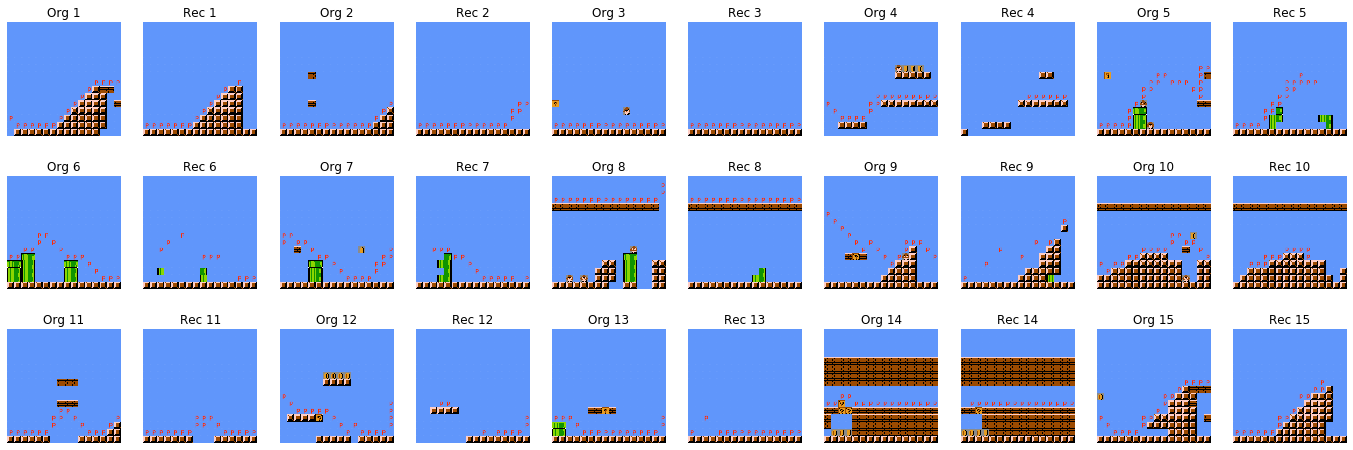

In [27]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(24, 8))
axes = axes.flatten()
nrows, ncols = 3, 10

org_idxs = np.arange(0, 29, 2)
rec_idxs = org_idxs + 1

for idx in org_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(org_images[idx // 2]))
    ax.set_title(f'Org {idx // 2 + 1}')
    
    ax.axis('off')

for idx in rec_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(rec_images[idx // 2]))
    ax.set_title(f'Rec {idx // 2 + 1}')

    ax.axis('off')
    
plt.show()

## Random Generation per Category

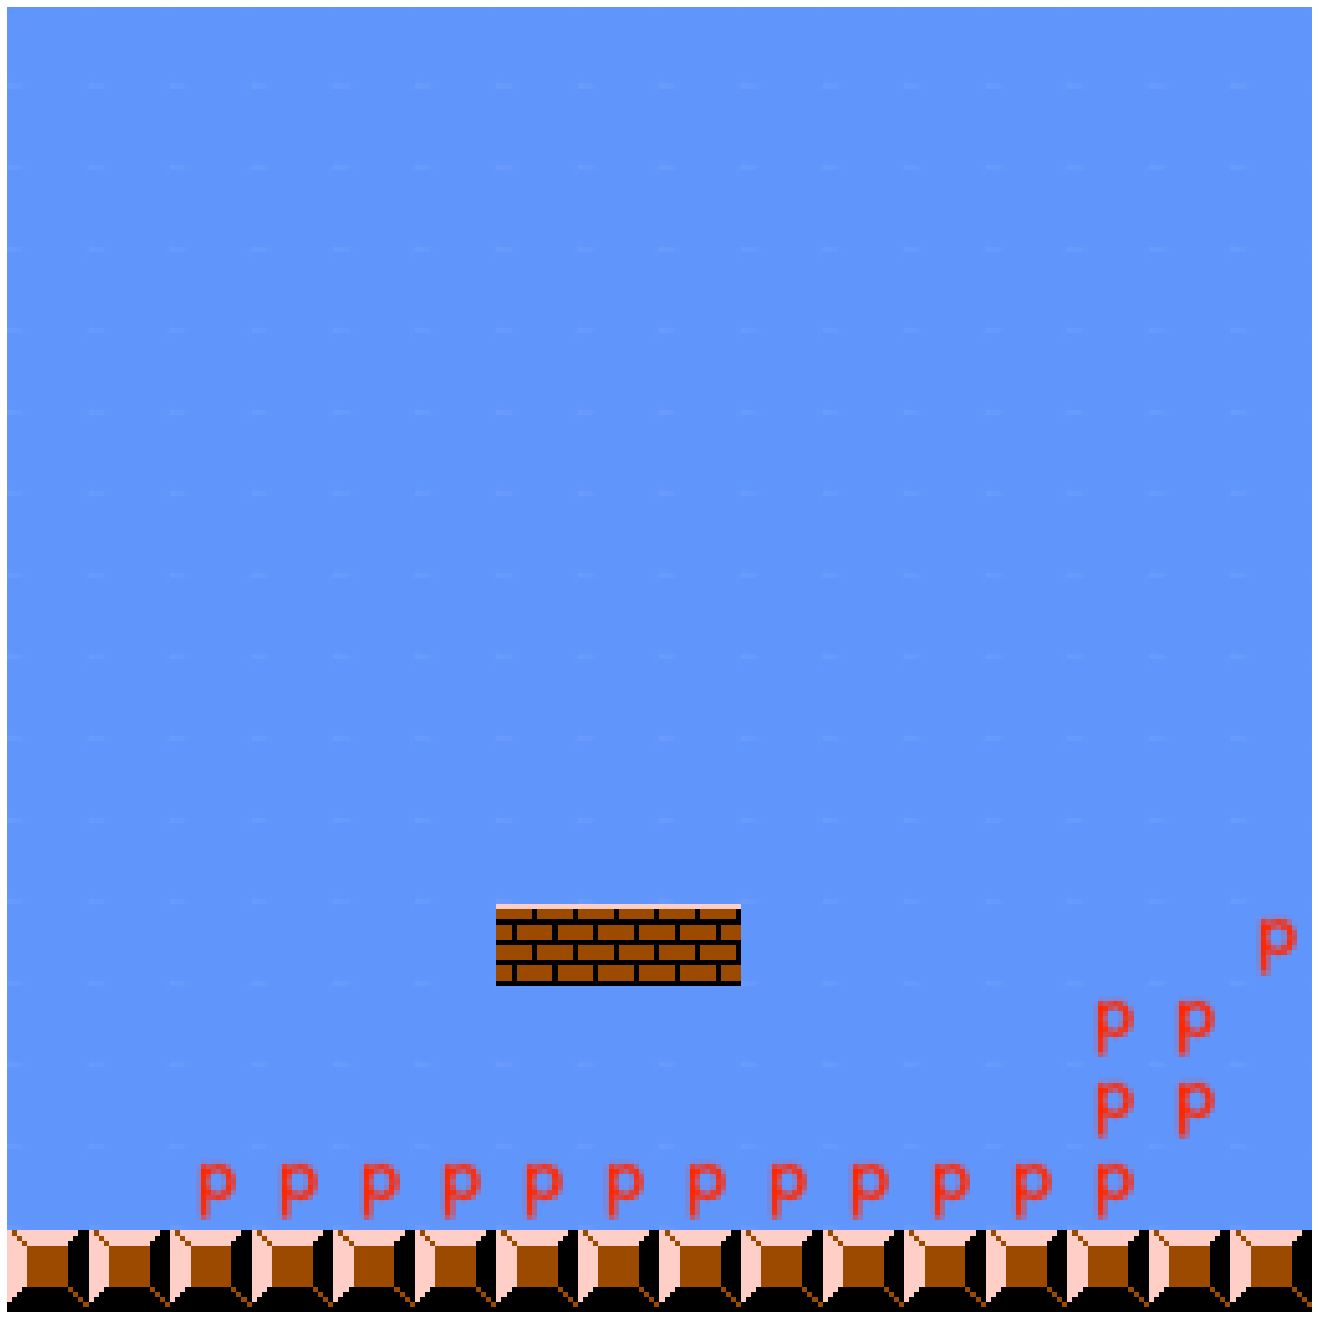

In [28]:
def display_random_generation(generated, num_classes, n=10):
    plt.figure(figsize=[24,5])
    for c in range(num_classes):
        for i in range(n):
            plt.subplot(num_classes, n, (c * n) + i + 1)
            chunk_int = generated[(c * n) + i].reshape(16, 16, 12).argmax(axis=-1)
            chunk_pix = vglc_with_path_encodings.array_to_image([chunk_int], game='smba')[0]
            plt.imshow(chunk_pix)
            plt.gray()
            plt.axis('off')
    plt.show()

elem_per_category = 15
generated = gmvae.random_generation(elem_per_category)
display_random_generation(generated, args.num_classes, elem_per_category)

In [24]:
elem_per_category = 10000 // num_components
generated = gmvae.random_generation(elem_per_category)

In [25]:
generated_int = generated.reshape(-1, 16, 16, 12).argmax(axis=-1)

In [26]:
generated_int.shape

(10000, 16, 16)

In [28]:
# since this code chunk depends on random seed, it shouldn't be run again
with open(f'../smba_generations/smba_gmvae_{num_components}_{num_epochs}.json', 'w+') as json_f:
    json.dump(generated_int.tolist(), json_f)

## Visualization of the feature latent space

In [33]:
# get feature representations
test_features, test_labels = gmvae.latent_features(train_dl, True)

In [34]:
# import TSNE from scikit-learn library
from sklearn.manifold import TSNE

# reduce dimensionality to 2D, we consider a subset of data because TSNE
# is a slow algorithm

first_n = 1000
tsne_features = TSNE(n_components=2).fit_transform(test_features[:first_n])

In [35]:
test_labels_subset = test_labels[:first_n]

In [36]:
X_, Y_ = np.s_[:,0], np.s_[:,1]

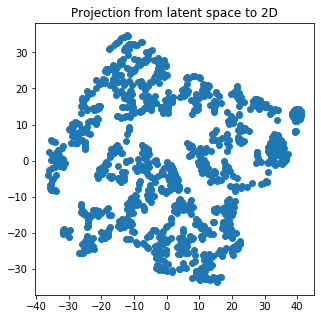

In [37]:
fig = plt.figure(figsize=(5, 5))

plt.scatter(tsne_features[X_], tsne_features[Y_])

plt.title('Projection from latent space to 2D')
plt.show()